> 此ipynb檔修改自：https://www.kaggle.com/code/ftaham/hr-analytics-predicting-job-change  
> 資料集來源： https://www.kaggle.com/datasets/arashnic/hr-analytics-job-change-of-data-scientists/data


# Topic 1作業： HR Analytics: Job Change of Data Scientists (binary classfication)
* **1. 作業說明:**
    - 任務目標: 為了協助公司進行人力資源管理，請你幫公司預測哪些培訓者真正想在培訓後為公司工作，哪些會想尋找新工作(二元分類)。為了解釋給老闆你需要用可解釋性方法解釋你的預測結果。
    - 請填補程式中空缺(TODO:)部分:完成二元分類模型，及利用可解釋性方法解釋模型。最後請說明你於可解釋性方法中的發現。試著提高預測效果吧！
    - 當然，你也可以修改其他部分以提高預測效果。(不強制)
* **2. 學習目標:**
    - 資料前處理
    - 缺失值填補
    - 類別不平衡處理
    - 機器學習分類模型

* **資料集背景**
    - 一家活躍於大數據和數據科學領域的公司希望從通過公司舉辦的課程中成功畢業的人中招聘數據科學家。許多人報名參加了這些培訓。公司希望了解哪些候選人真正想在培訓後為公司工作，哪些是正在尋找新工作的。這有助於降低成本和時間，並提高培訓的質量，同時優化課程規劃和候選人分類。公司已經掌握了與候選人報名和注冊相關的人口統計、教育背景和工作經驗等信息。

    - 該數據集還旨在幫助人力資源研究，了解導致個人離開當前工作的因素。通過利用現有的資格證書、人口統計數據和工作經驗數據，您可以構建模型，預測候選人是否會尋找新工作，或者是否會留在公司工作，並解釋影響員工決策的因素。

    - 整個數據集分為訓練集和測試集。測試集中不包含目標標簽，但相關任務的測試目標值數據文件已提供。此外，還提供了對應測試集的enrollee_id的樣本提交文件，包含的列有：enrollee_id和target。-

    - **Note**：
        - The dataset is imbalanced.
        - Most features are categorical (Nominal, Ordinal, Binary), some with high cardinality.
        - Missing imputation can be a part of your pipeline as well.

- features
    - enrollee_id : Unique ID for candidate.
    - city: City code.
    - city_ development _index : Developement index of the city (scaled).
    - gender: Gender of candidate
    - relevent_experience: Relevant experience of candidate
    - enrolled_university: Type of University course enrolled if any
    - education_level: Education level of candidate
    - major_discipline :Education major discipline of candidate
    - experience: Candidate total experience in years
    - company_size: No of employees in current employer's company
    - company_type : Type of current employer
    - last_new_job: Difference in years between previous job and current job
    - training_hours: training hours completed

- label
    - target: 0 – Not looking for job change, 1 – Looking for a job change

**注意事項:**
1. 請將aug_train.csv放到"./data/"底下
2. 不要更動產生數值型缺失值的程式

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

from sklearn.metrics import classification_report,confusion_matrix

In [2]:
df=pd.read_csv("data/aug_train.csv")

原本數據集中沒有數值型缺失值，為了模擬有缺失值的情境隨機將部分資料數值替換為缺失值。

**(請勿修改此cell)**

In [3]:
np.random.seed(0)
# 挑出數值型特徵
num_feat= df.drop("target",axis=1).select_dtypes("number").columns
# 隨機將200筆資料數值替換為缺失值
for col in num_feat:
    idx=np.random.choice(df.index,size=200,replace=False)
    df.loc[idx,col]=np.nan

In [4]:
df.head()

,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target
0,8949.0,city_103,0.920,Male,Has relevent experience,no_enrollment,Graduate,STEM,>20,NaN,NaN,1,36.0,1.0
1,29725.0,city_40,0.776,Male,No relevent experience,no_enrollment,Graduate,STEM,15,50-99,Pvt Ltd,>4,47.0,0.0
2,11561.0,city_21,0.624,NaN,No relevent experience,Full time course,Graduate,STEM,5,NaN,NaN,never,83.0,0.0
3,33241.0,city_115,0.789,NaN,No relevent experience,NaN,Graduate,Business Degree,<1,NaN,Pvt Ltd,never,52.0,1.0
4,666.0,city_162,0.767,Male,Has relevent experience,no_enrollment,Masters,STEM,>20,50-99,Funded Startup,4,8.0,0.0


In [4]:
# id特徵不重要，刪除
df.drop("enrollee_id",axis=1,inplace=True)

# **Data Exploration**

In [5]:
df.drop("target",axis=1).shape # we have 19158 example and 12 features

(19158, 12)

In [7]:
df.info() # most of the features have missing values and most of them are object kind

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19158 entries, 0 to 19157
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   city                    19158 non-null  object 
 1   city_development_index  18958 non-null  float64
 2   gender                  14650 non-null  object 
 3   relevent_experience     19158 non-null  object 
 4   enrolled_university     18772 non-null  object 
 5   education_level         18698 non-null  object 
 6   major_discipline        16345 non-null  object 
 7   experience              19093 non-null  object 
 8   company_size            13220 non-null  object 
 9   company_type            13018 non-null  object 
 10  last_new_job            18735 non-null  object 
 11  training_hours          18958 non-null  float64
 12  target                  19158 non-null  float64
dtypes: float64(3), object(10)
memory usage: 1.9+ MB


In [8]:
df.describe() # there are cleary varity in the numarical features range so we will need scaling
             # and they elso show a clear skewedness

,city_development_index,training_hours,target
count,18958.000000,18958.000000,19158.000000
mean,0.828898,65.381475,0.249348
std,0.123434,60.066121,0.432647
min,0.448000,1.000000,0.000000
25%,0.740000,23.000000,0.000000
50%,0.903000,47.000000,0.000000
75%,0.920000,88.000000,0.000000
max,0.949000,336.000000,1.000000


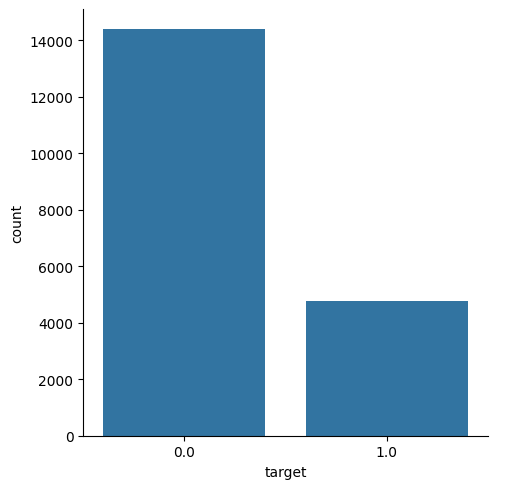

In [9]:
sns.catplot(x="target",data=df,kind="count")
plt.show() # clear imbalanced shown in the target

In [10]:
df.nunique() # The 'city' feature has 123 unique values, making it a high-cardinality categorical variable.
             # Using One-Hot Encoding would result in a very sparse matrix due to the large number of unique categories.
             # To avoid this issue and reduce dimensionality, we can use Frequency Encoding,
             # which replaces each city with the frequency of its occurrence in the dataset.(用該city出現的次數(數值型)來取代city(類別型))


city                      123
city_development_index     93
gender                      3
relevent_experience         2
enrolled_university         3
education_level             5
major_discipline            6
experience                 22
company_size                8
company_type                6
last_new_job                6
training_hours            241
target                      2
dtype: int64

In [6]:
# performe frquent encoder (用該city出現的次數(數值型)來取代city(類別型))
city_freq=df["city"].value_counts(normalize=True)
df["city_freq"]=df["city"].map(city_freq)
df.drop("city",axis=1,inplace=True)

In [7]:
# 挑出數值型特徵
num_feat= df.drop("target",axis=1).select_dtypes("number").columns
# 挑出類別型特徵
cat_feat= df.drop("target",axis=1).select_dtypes("object").columns
print(num_feat)
print(cat_feat)

Index(['city_development_index', 'training_hours', 'city_freq'], dtype='object')
Index(['gender', 'relevent_experience', 'enrolled_university',
       'education_level', 'major_discipline', 'experience', 'company_size',
       'company_type', 'last_new_job'],
      dtype='object')


## **Categorical Analysis**

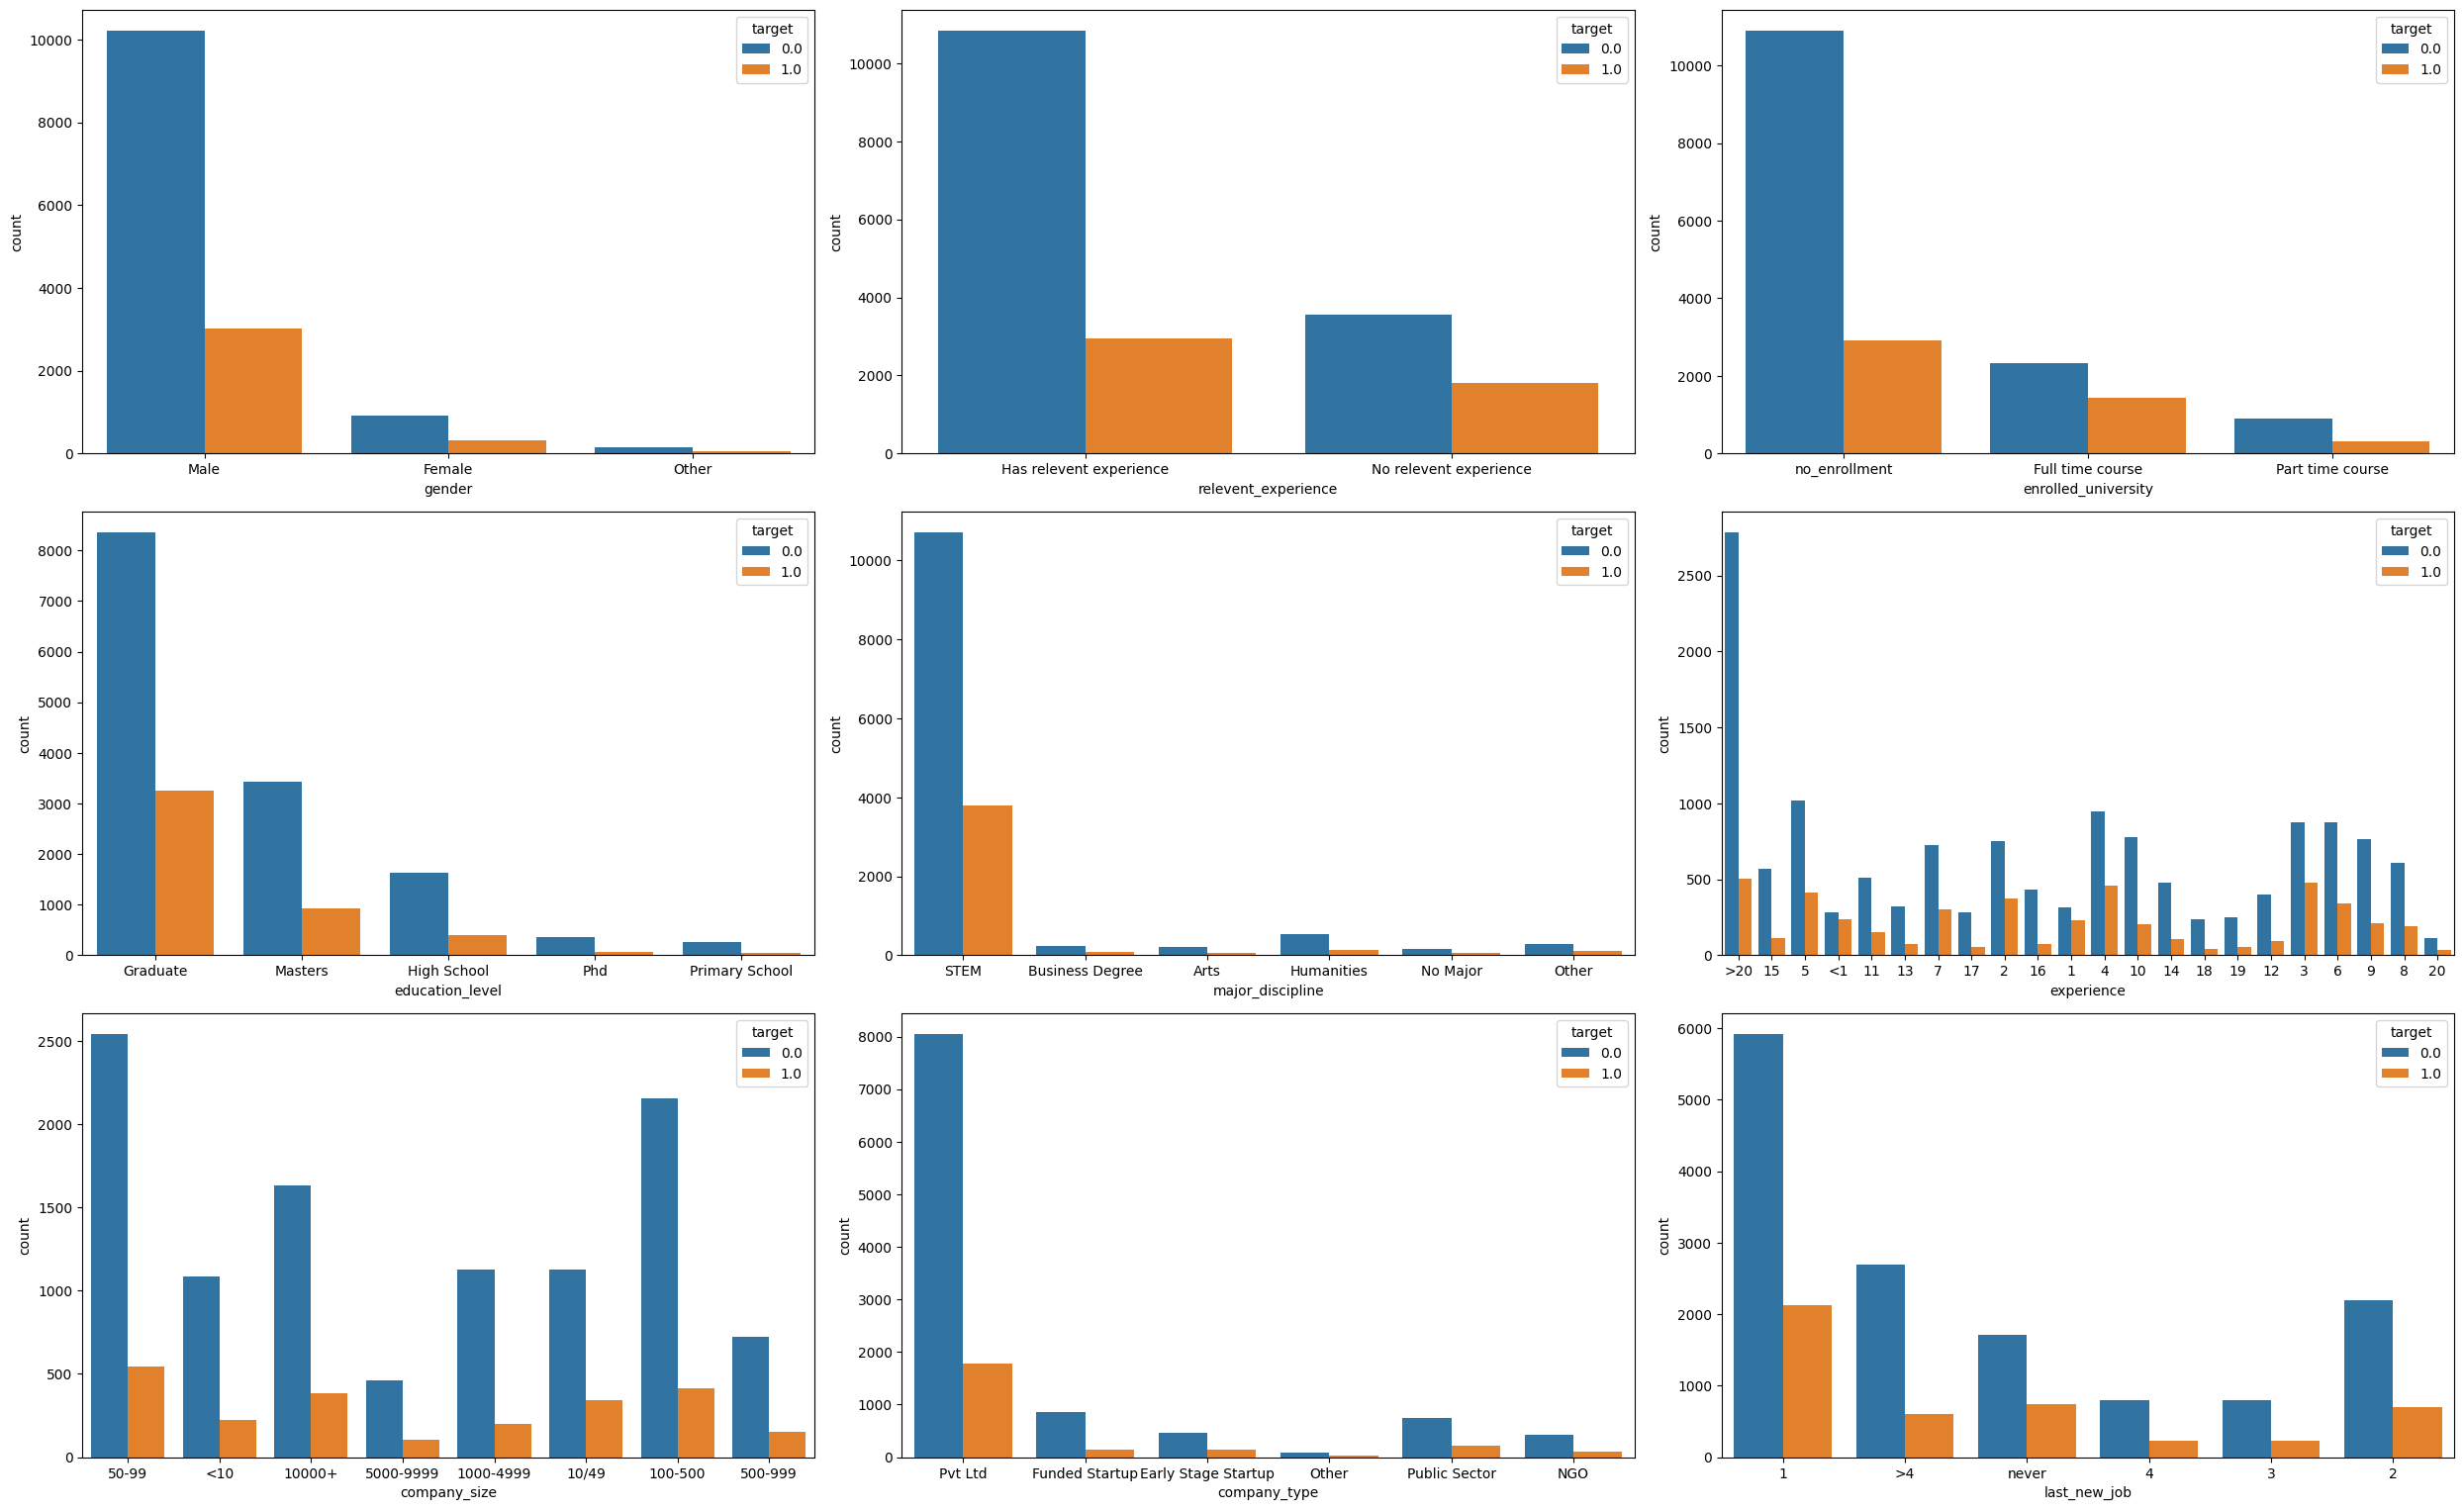

In [13]:
plt.figure(figsize=(25,20))
for i in range(len(cat_feat)):
    plt.subplot(4,3,i+1)
    sns.countplot(x=cat_feat[i],data=df.drop("target",axis=1),hue=df['target'])
plt.tight_layout()
plt.show()

## **Numarical Analysis**

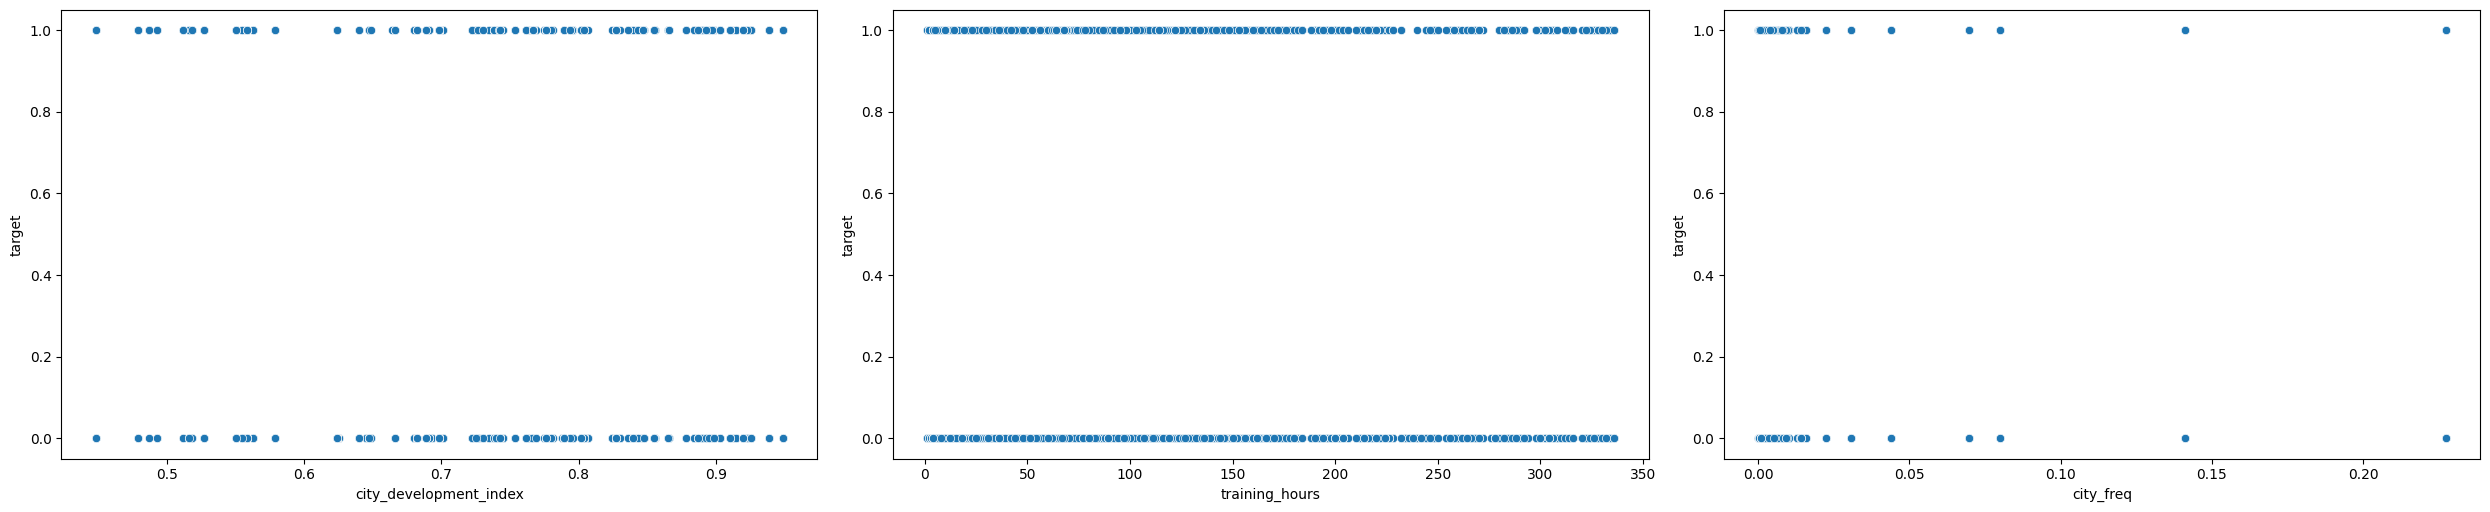

In [14]:
plt.figure(figsize=(25,20))
for i in range(len(num_feat)):
    plt.subplot(4,3,i+1)
    sns.scatterplot(x=num_feat[i],data=df.drop("target",axis=1),y=df['target'])
plt.tight_layout()
plt.show()

#Based on these scatter plots, it does seem that neither city_development_index nor training_hours has a strong linear relationship
#with the target variable. However, this does not necessarily mean they are not useful in prediction.

<!-- # **Stratified Split** -->

# **Data Preprocessing**

## 1. Missing value imputation

In [15]:
! pip install fancyimpute
! pip install miceforest

  Using cached iniconfig-2.1.0-py3-none-any.whl.metadata (2.7 kB)
Using cached iniconfig-2.1.0-py3-none-any.whl (6.0 kB)


In [16]:
df.isnull().sum() # there are missing values

city_development_index     200
gender                    4508
relevent_experience          0
enrolled_university        386
education_level            460
major_discipline          2813
experience                  65
company_size              5938
company_type              6140
last_new_job               423
training_hours             200
target                       0
city_freq                    0
dtype: int64

In [8]:
# 填補類別型特徵
cat_imputer = SimpleImputer(strategy="most_frequent")
df[cat_feat] = cat_imputer.fit_transform(df[cat_feat])

#### 自行實作版本，使用MICE填補。

In [ ]:
from fancyimpute import SimpleFill
# 填補數值型特徵
########### TODO: 嘗試其他進階的填補方法(ex.MICE, KNN...) ##############
# num_imputer = SimpleFill(fill_method='mean')

import miceforest as mf

# 建立 kernel
num_imputer = mf.ImputationKernel(
    data=df[num_feat],    # 需要填補的數據
    num_datasets=5,       # 生成多少個填補後的數據集
    random_state=666
)

# 跑 MICE 迭代
num_imputer.mice(5)

# 填補後的數據
df[num_feat] = num_imputer.complete_data(dataset=0)

#########################################################
# df[num_feat] = num_imputer.fit_transform(df[num_feat])

In [9]:
print(num_imputer) # check the imputer result


              Class: ImputationKernel
            Datasets: 5
          Iterations: 5
        Data Samples: 19158
        Data Columns: 3
   Imputed Variables: 2
   Modeled Variables: 2
All Iterations Saved: True
        


In [10]:
df.isnull().sum() # there are no missing values

city_development_index    0
gender                    0
relevent_experience       0
enrolled_university       0
education_level           0
major_discipline          0
experience                0
company_size              0
company_type              0
last_new_job              0
training_hours            0
target                    0
city_freq                 0
dtype: int64

## 2. One-Hot Encoder

In [11]:
# 對類別型資料做one-hot encodding
df_one_hot = pd.get_dummies(df[cat_feat])

df_target = df["target"]
df = pd.concat([df[num_feat], df_one_hot], axis=1)
df = pd.concat([df, df_target], axis=1)

In [12]:
# one-hot encodding後的資料
df

,city_development_index,training_hours,city_freq,gender_Female,gender_Male,gender_Other,relevent_experience_Has relevent experience,relevent_experience_No relevent experience,enrolled_university_Full time course,enrolled_university_Part time course,...,company_type_Other,company_type_Public Sector,company_type_Pvt Ltd,last_new_job_1,last_new_job_2,last_new_job_3,last_new_job_4,last_new_job_>4,last_new_job_never,target
0,0.920,36.0,0.227320,False,True,False,True,False,False,False,...,False,False,True,True,False,False,False,False,False,1.0
1,0.776,47.0,0.003549,False,True,False,False,True,False,False,...,False,False,True,False,False,False,False,True,False,0.0
2,0.624,83.0,0.141038,False,True,False,False,True,True,False,...,False,False,True,False,False,False,False,False,True,0.0
3,0.789,52.0,0.002819,False,True,False,False,True,False,False,...,False,False,True,False,False,False,False,False,True,1.0
4,0.767,8.0,0.006681,False,True,False,True,False,False,False,...,False,False,False,False,False,False,True,False,False,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19153,0.878,42.0,0.007882,False,True,False,False,True,False,False,...,False,False,True,True,False,False,False,False,False,1.0
19154,0.920,52.0,0.227320,False,True,False,True,False,False,False,...,False,False,True,False,False,False,True,False,False,1.0
19155,0.920,44.0,0.227320,False,True,False,True,False,False,False,...,False,False,True,False,False,False,True,False,False,0.0
19156,0.802,97.0,0.009135,False,True,False,True,False,False,False,...,False,False,True,False,True,False,False,False,False,0.0


## 3. normalize numerical features
對數值型特徵做normalization，使每個特徵的值被縮放到相同範圍。避免特徵值範圍不同影響模型訓練性能。

In [12]:
# Standard Scaler to normalize numerical features (zero mean, unit variance)
scaler = StandardScaler()
df[num_feat] = scaler.fit_transform(df[num_feat])

# **Stratified Split**
切分測試與訓練資料，並保持訓練與測試資料中各類別標籤比例相同

In [13]:
# first we split the data to train and test
# Stratified Split
x_train,x_test,y_train,y_test=train_test_split(df.drop("target",axis=1),df["target"],shuffle=True,stratify=df["target"],random_state=42)
x_train.shape,x_test.shape,y_train.shape,y_test.shape

print('All:', np.bincount(df["target"]) / float(len(df["target"])) * 100.0)
print('Training:', np.bincount(y_train) / float(len(y_train)) * 100.0)
print('Test:', np.bincount(y_test) / float(len(y_test)) * 100.0)

All: [75.06524689 24.93475311]
Training: [75.0626392 24.9373608]
Test: [75.07306889 24.92693111]


C:\Users\user\AppData\Local\Temp\ipykernel_29288\1924502620.py:6: DeprecationWarning: Non-integer input passed to bincount. In a future version of NumPy, this will be an error. (Deprecated NumPy 2.1)
  print('All:', np.bincount(df["target"]) / float(len(df["target"])) * 100.0)
C:\Users\user\AppData\Local\Temp\ipykernel_29288\1924502620.py:7: DeprecationWarning: Non-integer input passed to bincount. In a future version of NumPy, this will be an error. (Deprecated NumPy 2.1)
  print('Training:', np.bincount(y_train) / float(len(y_train)) * 100.0)
C:\Users\user\AppData\Local\Temp\ipykernel_29288\1924502620.py:8: DeprecationWarning: Non-integer input passed to bincount. In a future version of NumPy, this will be an error. (Deprecated NumPy 2.1)
  print('Test:', np.bincount(y_test) / float(len(y_test)) * 100.0)


# **Handling class imbalance problem**

In [29]:
! pip install imblearn

  Using cached imblearn-0.0-py2.py3-none-any.whl.metadata (355 bytes)
Using cached imblearn-0.0-py2.py3-none-any.whl (1.9 kB)


## **Oversampling**

In [14]:
from collections import Counter

print('\nImbalanced dataset: ', Counter(y_train))


Imbalanced dataset:  Counter({0.0: 10785, 1.0: 3583})


#### 教材版本

In [ ]:
"""
from imblearn.over_sampling import SMOTE

########### TODO: 嘗試其他resampling方法 #############
# smote = SMOTE()
# x_train, y_train = smote.fit_resample(x_train, y_train)
resampling =
x_train, y_train =
############################

print('Size of resampling X:', x_train.shape)
print('Size of resampling y:', y_train.shape)
print('Resampling dataset: ', Counter(y_train))
"""

Size of resampling X: (21570, 64)
Size of resampling y: (21570,)
Resampling dataset:  Counter({0.0: 10785, 1.0: 10785})


#### 自行實作版本，使用ADASYN(Adaptive Synthetic Sampling)自適應合成採樣。

In [ ]:
from imblearn.over_sampling import ADASYN
from collections import Counter

########### TODO: 嘗試其他resampling方法 #############
# 使用ADASYN方法進行過採樣，n_neighbors是指在生成新樣本時考慮的最近鄰數量
# 每個少數類別樣本需要合成多少新樣本是分別決定的，重採樣後的正負樣本不會一定是1:1
resampling = ADASYN(random_state=666, n_neighbors=5)   
x_train, y_train = resampling.fit_resample(x_train, y_train)
########################################################

print('Size of resampling X:', x_train.shape)    # 訓練集特徵數量
print('Size of resampling y:', y_train.shape)    # 訓練集標籤數量
print('Resampling dataset: ', Counter(y_train))  # 顯示重採樣後各類別的數量(這時正負樣本比例接近1:1)


Size of resampling X: (21349, 64)
Size of resampling y: (21349,)
Resampling dataset:  Counter({0.0: 10785, 1.0: 10564})


In [16]:
# 將資料轉成numpy array
x_train_array = x_train.to_numpy()
x_test_array = x_test.to_numpy()

y_train_array = y_train.to_numpy()
y_test_array = y_test.to_numpy()

# **Model Building**

## **Choicing Best Classifier**

- f1-score: The F1 score can be interpreted as a harmonic mean of the precision and recall, where an F1 score reaches its best value at 1 and worst score at 0. The relative contribution of precision and recall to the F1 score are equal.

The formula for the F1 score is:
![圖片](https://wikimedia.org/api/rest_v1/media/math/render/svg/fd71c2d3b8d5399fbcf448b410dc4330addbf722)

#### 教材版本

In [ ]:
########## TODO: 選擇你感興趣的model #############
# model = RandomForestClassifier()
# model =

In [ ]:
# model.fit(x_train_array,y_train_array)

RandomForestClassifier()

In [ ]:
# y_pred=model.predict(x_test_array)

In [ ]:
"""
from sklearn.metrics import accuracy_score, f1_score
accuracy = accuracy_score(y_test_array, y_pred)
print(f"Accuracy: {accuracy}")
f_1_score = f1_score(y_test_array, y_pred)
print(f"F1 Score: {f_1_score}")
"""

Accuracy: 0.7634655532359081
F1 Score: 0.505456132693147


In [ ]:
"""
y_train_pred=model.predict(x_train_array)
f_1_score_train = f1_score(y_train_array, y_train_pred)
print(f"train set F1 Score: {f_1_score_train}")
"""

train set F1 Score: 0.9988414662403262


#### 自行實作版本，使用數種集成MODEL來做比較。

In [ ]:
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, StackingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score, f1_score
import numpy as np
import pandas as pd
# from sklearn.model_selection import KFold, cross_val_score  # 表現、泛化能力不佳，可嘗試交叉驗證、KFold等方法。

第一版測試

In [ ]:
########## TODO: 選擇你感興趣的model #############

# 定義基礎模型
models = {
    "RandomForest": RandomForestClassifier(
        n_estimators=800,
        max_depth=15,
        min_samples_split=5,
        random_state=666,
        n_jobs=-1
    ),
    "XGBoost": XGBClassifier(
        n_estimators=800,
        learning_rate=0.05,
        max_depth=15,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=666,
        eval_metric="logloss",
        n_jobs=-1
    ),
    "LightGBM": LGBMClassifier(
        n_estimators=800,
        learning_rate=0.05,
        max_depth=-1,
        num_leaves=64,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=666,
        n_jobs=-1
    ),
    "CatBoost": CatBoostClassifier(
        iterations=800,
        depth=10,
        learning_rate=0.05,
        l2_leaf_reg=3,
        random_state=666,
        verbose=0
    )
}

# Ensemble & Stacking 
ensemble = VotingClassifier(
    estimators=[(name, model) for name, model in models.items()],
    voting="soft", n_jobs=-1
)

stacking = StackingClassifier(
    estimators=[(name, model) for name, model in models.items()],
    final_estimator=LGBMClassifier(
        n_estimators=800,
        learning_rate=0.05,
        num_leaves=32,
        random_state=666,
        n_jobs=-1
    ),
    passthrough=False,
    n_jobs=-1
)

models["Ensemble"] = ensemble
models["Stacking"] = stacking

# ====================================================
# 3️⃣ 訓練 + 預測 + 評估
# ====================================================
results = []

for name, model in models.items():
    print(f"Training {name} ...")
    model.fit(x_train_array, y_train_array)
    y_pred = model.predict(x_test_array)

    acc = accuracy_score(y_test_array, y_pred)
    f1 = f1_score(y_test_array, y_pred)

    results.append({
        "Model": name,
        "Accuracy": acc,
        "F1-Score": f1
    })

# ====================================================
# 4️⃣ 排名結果
# ====================================================
results_df = pd.DataFrame(results).sort_values(by="F1-Score", ascending=False).reset_index(drop=True)
print(results_df)

Training RandomForest ...
Training XGBoost ...
Training LightGBM ...


c:\Users\user\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Training CatBoost ...
Training Ensemble ...


c:\Users\user\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Training Stacking ...


c:\Users\user\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\user\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


          Model  Accuracy  F1-Score
0  RandomForest  0.753862  0.593308
1      Ensemble  0.769311  0.530786
2      LightGBM  0.769102  0.524914
3      CatBoost  0.773486  0.524748
4      Stacking  0.764092  0.500883
5       XGBoost  0.757620  0.481001


第二版測試，提高迭代次數等參數，嘗試提升表現效能。

In [37]:
########## TODO: 選擇你感興趣的model #############

# 定義基礎模型
models = {
    "RandomForest": RandomForestClassifier(
        n_estimators=1000,
        min_samples_split=5,
        random_state=666,
        n_jobs=-1
    ),
    "XGBoost": XGBClassifier(
        n_estimators=1200,
        learning_rate=0.03,
        max_depth=8,
        subsample=0.8,
        colsample_bytree=0.8,
        scale_pos_weight=3,  # class weight 調整
        random_state=666,
        eval_metric="logloss",
        n_jobs=-1
    ),

    "LightGBM": LGBMClassifier(
        n_estimators=1200,
        learning_rate=0.03,
        num_leaves=64,
        max_depth=-1,
        subsample=0.8,
        colsample_bytree=0.8,
        class_weight="balanced",  # 內建 balancing
        random_state=666,
        n_jobs=-1
    ),

    "CatBoost": CatBoostClassifier(
        iterations=1200,
        depth=8,
        learning_rate=0.03,
        l2_leaf_reg=5,
        random_state=666,
        class_weights=[1, 3],   # CatBoost 也支援 class weights
        verbose=0
    )

}

# Ensemble & Stacking 
ensemble = VotingClassifier(
    estimators=[(name, model) for name, model in models.items()],
    voting="soft", n_jobs=-1
)

stacking = StackingClassifier(
    estimators=[(name, model) for name, model in models.items()],
    final_estimator=LGBMClassifier(
        n_estimators=800,
        learning_rate=0.05,
        num_leaves=32,
        random_state=666,
        n_jobs=-1
    ),
    passthrough=False,
    n_jobs=-1
)

models["Ensemble"] = ensemble
models["Stacking"] = stacking

# ====================================================
# 3️⃣ 訓練 + 預測 + 評估
# ====================================================
results = []

for name, model in models.items():
    print(f"Training {name} ...")
    model.fit(x_train_array, y_train_array)
    y_pred = model.predict(x_test_array)

    acc = accuracy_score(y_test_array, y_pred)
    f1 = f1_score(y_test_array, y_pred)

    results.append({
        "Model": name,
        "Accuracy": acc,
        "F1-Score": f1
    })

# ====================================================
# 4️⃣ 排名結果
# ====================================================
results_df = pd.DataFrame(results).sort_values(by="F1-Score", ascending=False).reset_index(drop=True)
print(results_df)

Training RandomForest ...
Training XGBoost ...
Training LightGBM ...


c:\Users\user\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Training CatBoost ...
Training Ensemble ...


c:\Users\user\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Training Stacking ...
          Model  Accuracy  F1-Score
0      Ensemble  0.765136  0.583796
1      CatBoost  0.723382  0.581623
2       XGBoost  0.746764  0.576910
3  RandomForest  0.770146  0.545979
4      LightGBM  0.767223  0.527342
5      Stacking  0.756159  0.477171


c:\Users\user\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\user\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


#### 試試optuna

In [38]:
import optuna
from sklearn.metrics import accuracy_score, f1_score
from lightgbm import LGBMClassifier

def objective(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 500, 2000),
        "learning_rate": trial.suggest_float("learning_rate", 0.005, 0.2, log=True),
        "max_depth": trial.suggest_int("max_depth", -1, 20),
        "num_leaves": trial.suggest_int("num_leaves", 16, 256),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "min_child_samples": trial.suggest_int("min_child_samples", 10, 200),
        "reg_alpha": trial.suggest_float("reg_alpha", 1e-8, 10.0, log=True),
        "reg_lambda": trial.suggest_float("reg_lambda", 1e-8, 10.0, log=True),
        "random_state": 666,
        "n_jobs": -1
    }
    
    model = LGBMClassifier(**params)
    model.fit(x_train_array, y_train_array)
    y_pred = model.predict(x_test_array)
    
    acc = accuracy_score(y_test_array, y_pred)
    f1 = f1_score(y_test_array, y_pred)
    
    # 可以換成 f1 為主，或 acc+f1 加權
    return f1  

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50)

print("Best trial:")
trial = study.best_trial
print("F1 Score:", trial.value)
print("Best params:", trial.params)

[I 2025-09-10 13:05:27,659] A new study created in memory with name: no-name-fce2f50d-55aa-4b2f-a4ed-3feb8da7f5d2
c:\Users\user\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
[I 2025-09-10 13:05:33,258] Trial 0 finished with value: 0.4761491760624458 and parameters: {'n_estimators': 1780, 'learning_rate': 0.09545033789995867, 'max_depth': 16, 'num_leaves': 94, 'subsample': 0.6537759774195027, 'colsample_bytree': 0.8529617217407428, 'min_child_samples': 181, 'reg_alpha': 1.0082639309327975e-06, 'reg_lambda': 0.006927986546429944}. Best is trial 0 with value: 0.4761491760624458.
c:\Users\user\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
[I 2025-09-10 13:05:37,117] Trial 1 finished with value: 0.49491525423728816 and parameters: 

Best trial:
F1 Score: 0.6022957461174882
Best params: {'n_estimators': 523, 'learning_rate': 0.005008924392163075, 'max_depth': 9, 'num_leaves': 192, 'subsample': 0.5535119237971283, 'colsample_bytree': 0.9297911008830493, 'min_child_samples': 144, 'reg_alpha': 3.070888449354123, 'reg_lambda': 1.7932775669692494e-07}


In [40]:
import optuna
from sklearn.metrics import accuracy_score, f1_score
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier

def objective(trial):
    model_name = trial.suggest_categorical("model", ["LightGBM", "XGBoost", "RandomForest"])

    if model_name == "LightGBM":
        params = {
            "n_estimators": trial.suggest_int("n_estimators", 300, 5000),
            "learning_rate": trial.suggest_float("learning_rate", 0.002, 0.2, log=True),
            "max_depth": trial.suggest_int("max_depth", -1, 40),
            "num_leaves": trial.suggest_int("num_leaves", 16, 256),
            "subsample": trial.suggest_float("subsample", 0.5, 1.0),
            "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
            "min_child_samples": trial.suggest_int("min_child_samples", 10, 200),
            "reg_alpha": trial.suggest_float("reg_alpha", 1e-8, 10.0, log=True),
            "reg_lambda": trial.suggest_float("reg_lambda", 1e-8, 10.0, log=True),
            "random_state": 666,
            "n_jobs": -1
        }
        model = LGBMClassifier(**params)

    elif model_name == "XGBoost":
        params = {
            "n_estimators": trial.suggest_int("n_estimators", 300, 5000),
            "learning_rate": trial.suggest_float("learning_rate", 0.002, 0.2, log=True),
            "max_depth": trial.suggest_int("max_depth", 3, 50),
            "subsample": trial.suggest_float("subsample", 0.5, 1.0),
            "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
            "gamma": trial.suggest_float("gamma", 0, 5.0),
            "reg_alpha": trial.suggest_float("reg_alpha", 1e-8, 10.0, log=True),
            "reg_lambda": trial.suggest_float("reg_lambda", 1e-8, 10.0, log=True),
            "eval_metric": "logloss",
            "use_label_encoder": False,
            "random_state": 666,
            "n_jobs": -1
        }
        model = XGBClassifier(**params)

    else:  # RandomForest
        params = {
            "n_estimators": trial.suggest_int("n_estimators", 200, 7000),
            "max_depth": trial.suggest_int("max_depth", 5, 200),
            "min_samples_split": trial.suggest_int("min_samples_split", 2, 40),
            "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 40),
            "max_features": trial.suggest_categorical("max_features", ["sqrt", "log2", None]),
            "bootstrap": trial.suggest_categorical("bootstrap", [True, False]),
            "random_state": 666,
            "n_jobs": -1
        }
        model = RandomForestClassifier(**params)

    # fit
    model.fit(x_train_array, y_train_array)
    y_pred = model.predict(x_test_array)

    acc = accuracy_score(y_test_array, y_pred)
    f1 = f1_score(y_test_array, y_pred)

    # 👇 想提升 F1 可以換成 f1 或 acc+f1 的加權
    return f1

# ----------- 執行 Optuna --------------
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100)

print("Best trial:")
trial = study.best_trial
print("Best F1:", trial.value)
print("Best params:", trial.params)


[I 2025-09-10 13:20:04,844] A new study created in memory with name: no-name-1f3a024d-3062-45fb-b29f-80d2b2db1f6f
c:\Users\user\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
[I 2025-09-10 13:20:09,717] Trial 0 finished with value: 0.5408960131524866 and parameters: {'model': 'LightGBM', 'n_estimators': 3612, 'learning_rate': 0.02972234310513066, 'max_depth': 8, 'num_leaves': 19, 'subsample': 0.8351446990273356, 'colsample_bytree': 0.6622007632518123, 'min_child_samples': 128, 'reg_alpha': 7.749912792057595e-07, 'reg_lambda': 0.0005504020997172455}. Best is trial 0 with value: 0.5408960131524866.
[I 2025-09-10 13:23:04,357] Trial 1 finished with value: 0.5963272120200334 and parameters: {'model': 'RandomForest', 'n_estimators': 6359, 'max_depth': 158, 'min_samples_split': 11, 'min_samples_leaf': 39, 'max_features': None, 'bootstrap': True}. Best is trial 1 

Best trial:
Best F1: 0.6046353101567825
Best params: {'model': 'RandomForest', 'n_estimators': 5177, 'max_depth': 184, 'min_samples_split': 17, 'min_samples_leaf': 18, 'max_features': 'sqrt', 'bootstrap': False}


用 Optuna 找到的最佳參數試試看

In [42]:
from sklearn.metrics import accuracy_score, f1_score
from sklearn.ensemble import VotingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import RandomForestClassifier
import pandas as pd

# ========== 用 Optuna 找到的最佳參數 ==========
models = {
    "RandomForest": RandomForestClassifier(
        n_estimators=6971,
        max_depth=126,
        min_samples_split=38,
        min_samples_leaf=24,
        max_features="sqrt",
        bootstrap=False,
        random_state=666,
        n_jobs=-1
    ),
    "LightGBM": LGBMClassifier(
        n_estimators=523,
        learning_rate=0.005008924392163075,
        max_depth=9,
        num_leaves=192,
        subsample=0.5535119237971283,
        colsample_bytree=0.9297911008830493,
        min_child_samples=144,
        reg_alpha=3.070888449354123,
        reg_lambda=1.7932775669692494e-07,
        random_state=666,
        n_jobs=-1
    ),
    "XGBoost": XGBClassifier(
        n_estimators=2062,
        learning_rate=0.0032948503804379617,
        max_depth=43,
        subsample=0.5257325090502304,
        colsample_bytree=0.5339291410689933,
        gamma=4.276651252581944,
        reg_alpha=4.782618468758816,
        reg_lambda=5.824372818389731,
        eval_metric="logloss",
        use_label_encoder=False,
        random_state=666,
        n_jobs=-1
    ),
    "CatBoost": CatBoostClassifier(
        iterations=1200,
        depth=12,
        learning_rate=0.003,
        l2_leaf_reg=5,
        random_state=666,
        class_weights=[1, 3],
        verbose=0
    )
}

# Ensemble & Stacking
ensemble = VotingClassifier(
    estimators=[(name, model) for name, model in models.items()],
    voting="soft",
    n_jobs=-1
)

stacking = StackingClassifier(
    estimators=[(name, model) for name, model in models.items()],
    final_estimator=LGBMClassifier(
        n_estimators=600,
        learning_rate=0.005,
        num_leaves=64,
        random_state=666,
        n_jobs=-1
    ),
    passthrough=False,
    n_jobs=-1
)

models["Ensemble"] = ensemble
models["Stacking"] = stacking

# ========== 訓練 & 評估 ==========
results = []
for name, model in models.items():
    model.fit(x_train_array, y_train_array)
    y_pred = model.predict(x_test_array)

    acc = accuracy_score(y_test_array, y_pred)
    f1 = f1_score(y_test_array, y_pred)
    results.append([name, acc, f1])

# 排序結果
df_results = pd.DataFrame(results, columns=["Model", "Accuracy", "F1-Score"])
df_results = df_results.sort_values(by="F1-Score", ascending=False).reset_index(drop=True)

print(df_results)

In [43]:
print(df_results)

          Model  Accuracy  F1-Score
0  RandomForest  0.754906  0.604447
1      LightGBM  0.754071  0.602296
2       XGBoost  0.759081  0.598189
3      Ensemble  0.740084  0.596173
4      Stacking  0.748225  0.571429
5      CatBoost  0.626722  0.532182


### 作業最終表現呈現

### 最終表現一，持續優化中....

Data shapes: (21349, 64) (4790, 64) (21349,) (4790,)
訓練模型: RandomForest
訓練模型: LightGBM
訓練模型: XGBoost


c:\Users\user\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [21:01:32] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


計算 Ensemble / Stacking


c:\Users\user\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Ensemble (soft weighted) ACC=0.7570, F1=0.5901
Stacking (meta LGBM) ACC=0.7438, F1=0.5351


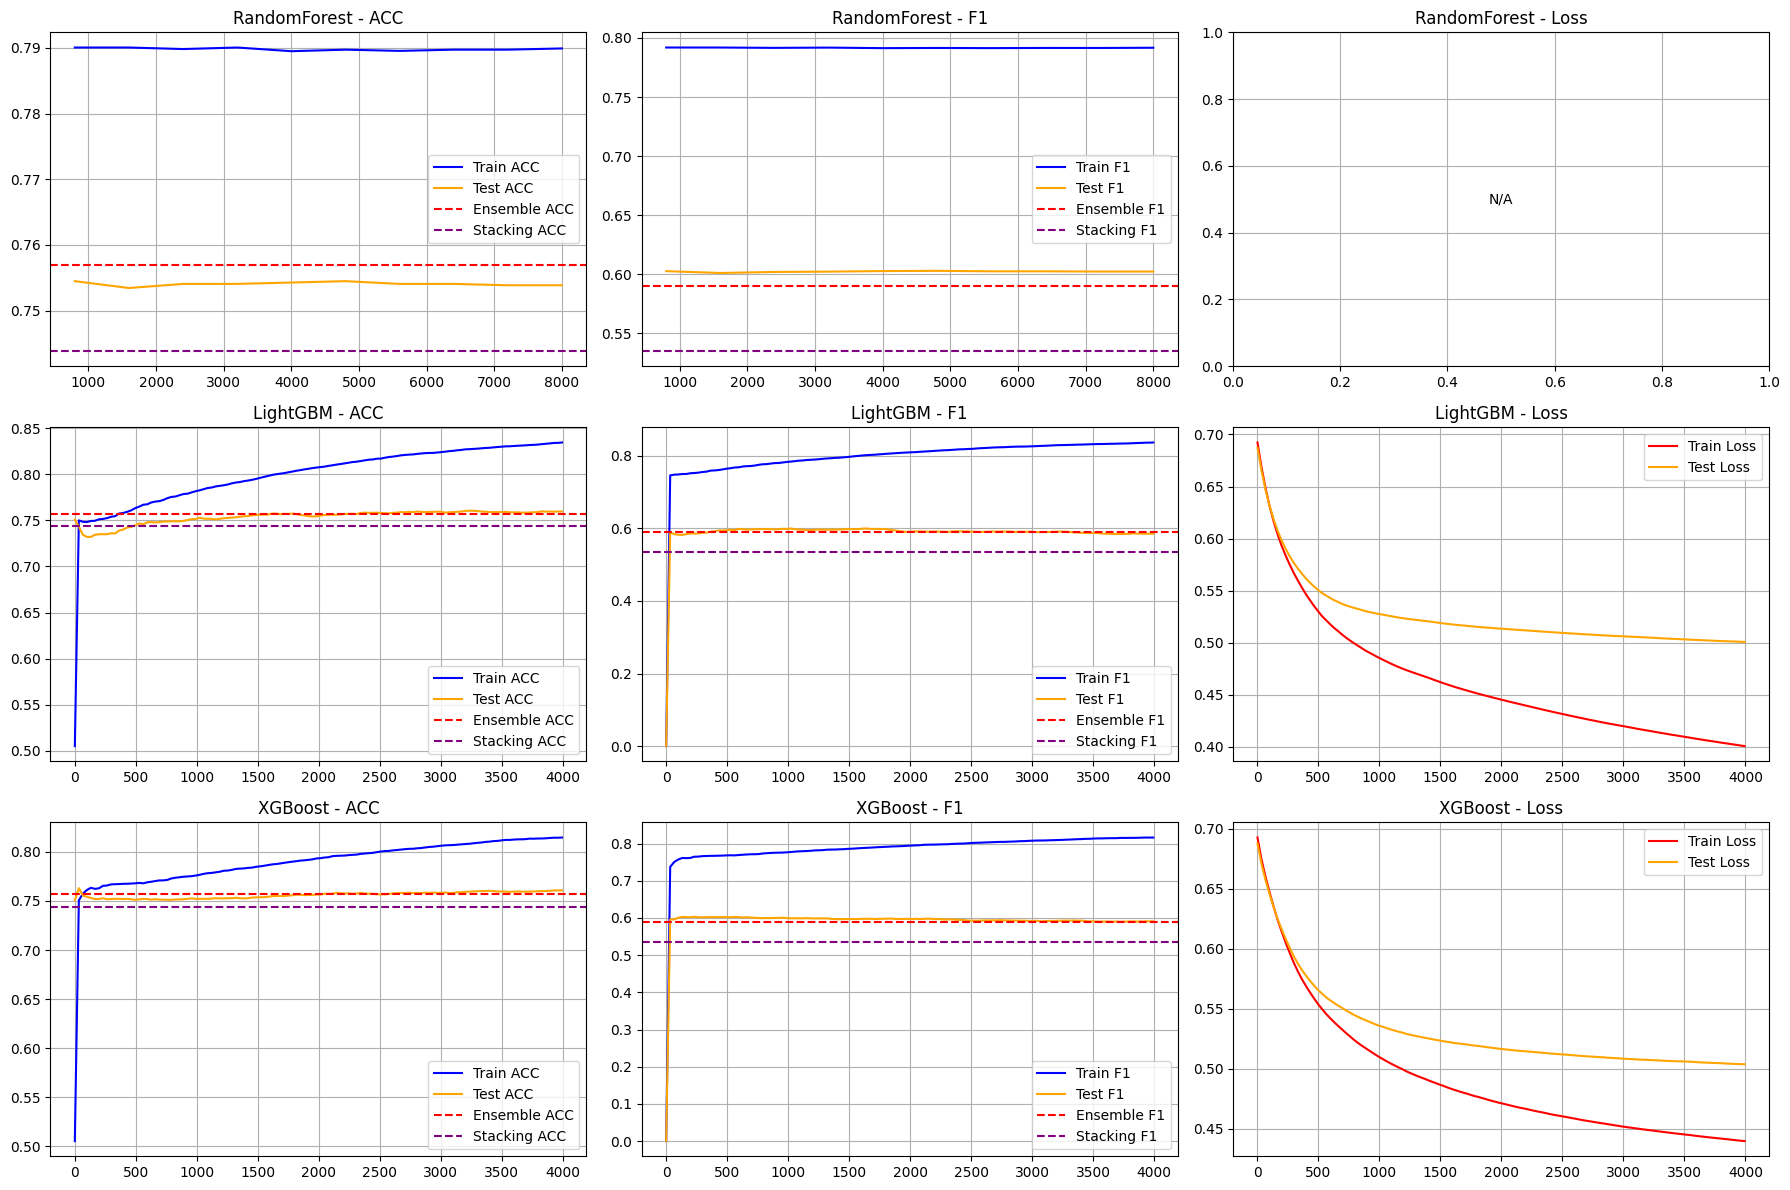


📊 Ranking by F1:
          Model  Accuracy        F1
0  RandomForest  0.753862  0.602361
1       XGBoost  0.760960  0.591217
2      Ensemble  0.756994  0.590141
3      LightGBM  0.759916  0.585735
4      Stacking  0.743841  0.535051


In [22]:
# 完整修正版：RF / LightGBM / XGBoost + 手動 Ensemble (soft voting) & Stacking (meta LGBM)
# import warnings
# warnings.filterwarnings("ignore")   # 執行時會抑制大量 sklearn/lightgbm 的警告（可拿掉看細節）

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# -------------------------------
# 1) 準備 X_train_df / X_test_df （確保 feature names 被保留）
#    如果你原本就有 x_train, x_test 為 DataFrame，會直接使用它們；如果只有 numpy arrays，會嘗試用原本的欄位名，否則自動產生 generic names
# -------------------------------
def ensure_dataframe(X_array_or_df, reference_df=None, name="X"):
    # return DataFrame version and columns
    if isinstance(X_array_or_df, pd.DataFrame):
        return X_array_or_df.copy()
    try:
        # if it's numpy array, try to get column names from reference_df if provided
        arr = np.asarray(X_array_or_df)
        if reference_df is not None and isinstance(reference_df, pd.DataFrame):
            cols = list(reference_df.columns)
        else:
            cols = [f"f{i}" for i in range(arr.shape[1])]
        return pd.DataFrame(arr, columns=cols)
    except Exception:
        raise ValueError(f"Cannot convert {name} to DataFrame")

# Try to locate training variables in current namespace
# (the user said they have x_train, x_test, x_train_array, x_test_array)
globals_vars = globals()

# Prefer x_train (DataFrame) if exists, else x_train_array
if 'x_train' in globals_vars and isinstance(globals_vars['x_train'], pd.DataFrame):
    X_train_df = globals_vars['x_train'].copy()
    X_test_df  = globals_vars['x_test'].copy()
else:
    # fallback to arrays; try to use x_train_array and original column names if available
    X_train_arr = globals_vars.get('x_train_array', globals_vars.get('x_train', None))
    X_test_arr  = globals_vars.get('x_test_array', globals_vars.get('x_test', None))
    # try to find a reference df for columns
    ref_df = globals_vars.get('x_train', None)
    X_train_df = ensure_dataframe(X_train_arr, reference_df=ref_df, name='x_train')
    X_test_df  = ensure_dataframe(X_test_arr, reference_df=ref_df, name='x_test')

# Targets
if 'y_train' in globals_vars and 'y_test' in globals_vars:
    y_train = globals_vars['y_train']
    y_test  = globals_vars['y_test']
else:
    # try numpy arrays
    y_train = globals_vars.get('y_train_array', globals_vars.get('y_train', None))
    y_test  = globals_vars.get('y_test_array', globals_vars.get('y_test', None))

# ensure shapes
X_train_df = pd.DataFrame(X_train_df)
X_test_df  = pd.DataFrame(X_test_df)
y_train = np.asarray(y_train)
y_test  = np.asarray(y_test)

# Fix feature names for LightGBM compatibility (remove [, ], < characters)
def clean_feature_names(df):
    """Clean feature names to be compatible with LightGBM"""
    new_columns = []
    for col in df.columns:
        # Replace problematic characters
        new_col = str(col).replace('[', '').replace(']', '').replace('<', 'less_than_')
        new_columns.append(new_col)
    df.columns = new_columns
    return df

X_train_df = clean_feature_names(X_train_df)
X_test_df = clean_feature_names(X_test_df)

print("Data shapes:", X_train_df.shape, X_test_df.shape, y_train.shape, y_test.shape)

# -------------------------------
# 2) 建模參數（你指定的大模型）
# -------------------------------
rf_params = dict(
    n_estimators=8000,
    warm_start=True,
    max_depth=126,
    min_samples_split=38,
    min_samples_leaf=24,
    max_features="sqrt",
    bootstrap=False,
    random_state=666,
    n_jobs=-1
)
lgb_params = dict(
    n_estimators=4000,
    learning_rate=0.003,
    max_depth=9,
    num_leaves=192,
    subsample=0.55,
    colsample_bytree=0.93,
    min_child_samples=144,
    reg_alpha=3.07,
    reg_lambda=1.79e-07,
    random_state=666,
    n_jobs=-1
)
xgb_params = dict(
    n_estimators=4000,
    learning_rate=0.003,
    max_depth=43,
    subsample=0.52,
    colsample_bytree=0.53,
    gamma=4.27,
    reg_alpha=4.78,
    reg_lambda=5.82,
    eval_metric="logloss",
    random_state=666,
    n_jobs=-1,
    use_label_encoder=False
)

# instantiate models
rf_model = RandomForestClassifier(**rf_params)
lgb_model = LGBMClassifier(**lgb_params)
xgb_model = XGBClassifier(**xgb_params)

# -------------------------------
# 3) 訓練：RF (每800棵樹取樣 10 個點)，LGBM/XGB(記錄 evals_result 並每 step 評估 ACC/F1)
# -------------------------------
history = {}
final_metrics = {}

# ----- RandomForest: 每 800 棵一點 (10 points) -----
print("訓練模型: RandomForest")
n_points_rf = 10
max_trees = rf_params['n_estimators']
step_rf = max(1, max_trees // n_points_rf)
n_trees_list = list(range(step_rf, max_trees+1, step_rf))[:n_points_rf]  # 確保 10 個點
acc_train_rf, acc_test_rf, f1_train_rf, f1_test_rf = [], [], [], []

for n in n_trees_list:
    rf_model.set_params(n_estimators=n)
    rf_model.fit(X_train_df, y_train)
    # train / test predictions
    y_tr = rf_model.predict(X_train_df)
    y_te = rf_model.predict(X_test_df)
    acc_train_rf.append(accuracy_score(y_train, y_tr))
    acc_test_rf.append(accuracy_score(y_test, y_te))
    f1_train_rf.append(f1_score(y_train, y_tr))
    f1_test_rf.append(f1_score(y_test, y_te))

history['RandomForest'] = {
    "iters": n_trees_list,
    "acc_train": acc_train_rf, "acc_test": acc_test_rf,
    "f1_train": f1_train_rf, "f1_test": f1_test_rf,
    "loss_train": None, "loss_test": None
}
final_metrics['RandomForest'] = {"acc": acc_test_rf[-1], "f1": f1_test_rf[-1]}

# ----- LightGBM: 訓練並取得 evals_result，為避免太慢只採樣 n_points 個點 -----
print("訓練模型: LightGBM")
# fit with eval_set to record training & validation loss
lgb_model.fit(
    X_train_df, y_train,
    eval_set=[(X_train_df, y_train), (X_test_df, y_test)],
    eval_metric="binary_logloss",
    callbacks=[lgb.log_evaluation(0)]  # no printing but keep evals_result_
)
evals_lgb = lgb_model.evals_result_
loss_train_full = evals_lgb['training']['binary_logloss']
loss_test_full  = evals_lgb['valid_1']['binary_logloss']

n_points = 120  # number of points to sample for plotting (調整以免太慢)
step = max(1, len(loss_train_full) // n_points)
iters_lgb = list(range(1, len(loss_train_full)+1, step))
acc_train_lgb, acc_test_lgb, f1_train_lgb, f1_test_lgb = [], [], [], []
for it in iters_lgb:
    # LightGBM scikit wrapper supports predict_proba with num_iteration
    prob_tr = lgb_model.predict_proba(X_train_df, num_iteration=it)[:,1]
    prob_te = lgb_model.predict_proba(X_test_df, num_iteration=it)[:,1]
    pred_tr = (prob_tr > 0.5).astype(int)
    pred_te = (prob_te > 0.5).astype(int)
    acc_train_lgb.append(accuracy_score(y_train, pred_tr))
    acc_test_lgb.append(accuracy_score(y_test, pred_te))
    f1_train_lgb.append(f1_score(y_train, pred_tr))
    f1_test_lgb.append(f1_score(y_test, pred_te))

history['LightGBM'] = {
    "iters": iters_lgb,
    "acc_train": acc_train_lgb, "acc_test": acc_test_lgb,
    "f1_train": f1_train_lgb, "f1_test": f1_test_lgb,
    "loss_train": [loss_train_full[i-1] for i in iters_lgb],
    "loss_test": [loss_test_full[i-1] for i in iters_lgb]
}
final_metrics['LightGBM'] = {"acc": accuracy_score(y_test, (lgb_model.predict_proba(X_test_df)[:,1]>0.5).astype(int)),
                            "f1": f1_score(y_test, (lgb_model.predict_proba(X_test_df)[:,1]>0.5).astype(int))}

# ----- XGBoost: fit and record evals_result; sample points -----
print("訓練模型: XGBoost")
xgb_model.fit(
    X_train_df, y_train,
    eval_set=[(X_train_df, y_train), (X_test_df, y_test)],
    verbose=False
)
evals_xgb = xgb_model.evals_result()
loss_train_full_x = evals_xgb['validation_0']['logloss']
loss_test_full_x  = evals_xgb['validation_1']['logloss']

step_x = max(1, len(loss_train_full_x)//n_points)
iters_xgb = list(range(1, len(loss_train_full_x)+1, step_x))
acc_train_xgb, acc_test_xgb, f1_train_xgb, f1_test_xgb = [], [], [], []
for it in iters_xgb:
    try:
        prob_tr = xgb_model.predict_proba(X_train_df, iteration_range=(0, it))[:,1]
        prob_te = xgb_model.predict_proba(X_test_df, iteration_range=(0, it))[:,1]
    except TypeError:
        # older xgboost versions may not support iteration_range in sklearn wrapper
        # fallback: use raw booster
        from xgboost import DMatrix
        dtr = DMatrix(X_train_df, label=y_train)
        dte = DMatrix(X_test_df, label=y_test)
        prob_tr = xgb_model.get_booster().predict(dtr, ntree_limit=it)
        prob_te = xgb_model.get_booster().predict(dte, ntree_limit=it)
    pred_tr = (prob_tr > 0.5).astype(int)
    pred_te = (prob_te > 0.5).astype(int)
    acc_train_xgb.append(accuracy_score(y_train, pred_tr))
    acc_test_xgb.append(accuracy_score(y_test, pred_te))
    f1_train_xgb.append(f1_score(y_train, pred_tr))
    f1_test_xgb.append(f1_score(y_test, pred_te))

history['XGBoost'] = {
    "iters": iters_xgb,
    "acc_train": acc_train_xgb, "acc_test": acc_test_xgb,
    "f1_train": f1_train_xgb, "f1_test": f1_test_xgb,
    "loss_train": [loss_train_full_x[i-1] for i in iters_xgb],
    "loss_test":  [loss_test_full_x[i-1] for i in iters_xgb]
}
final_metrics['XGBoost'] = {"acc": accuracy_score(y_test, (xgb_model.predict_proba(X_test_df)[:,1]>0.5).astype(int)),
                            "f1": f1_score(y_test, (xgb_model.predict_proba(X_test_df)[:,1]>0.5).astype(int))}

# -------------------------------
# 4) 手動 Ensemble (soft voting by probability) 與 Stacking (meta-learner)
#    Use the trained models above, combine predict_proba on X_test/X_train
# -------------------------------
print("計算 Ensemble / Stacking")

# base model probabilities on train and test
prob_train_stack = np.vstack([
    rf_model.predict_proba(X_train_df)[:,1],
    lgb_model.predict_proba(X_train_df)[:,1],
    xgb_model.predict_proba(X_train_df)[:,1]
]).T
prob_test_stack = np.vstack([
    rf_model.predict_proba(X_test_df)[:,1],
    lgb_model.predict_proba(X_test_df)[:,1],
    xgb_model.predict_proba(X_test_df)[:,1]
]).T

# weights from base final f1 (to favor better models)
w_rf = final_metrics['RandomForest']['f1']
w_lgb = final_metrics['LightGBM']['f1']
w_xgb = final_metrics['XGBoost']['f1']
weights = np.array([w_rf, w_lgb, w_xgb])
# avoid zero
weights = np.where(weights <= 0, 1.0, weights)

# soft voting
prob_test_ens = (prob_test_stack * weights.reshape(1,-1)).sum(axis=1) / weights.sum()
pred_test_ens = (prob_test_ens > 0.5).astype(int)
ens_acc = accuracy_score(y_test, pred_test_ens)
ens_f1  = f1_score(y_test, pred_test_ens)

# stacking: train meta-learner on train-level probs
meta = LGBMClassifier(n_estimators=1500, learning_rate=0.005, num_leaves=64, random_state=666)
meta.fit(prob_train_stack, y_train)
prob_test_meta = meta.predict_proba(prob_test_stack)[:,1]
pred_test_meta = (prob_test_meta > 0.5).astype(int)
stack_acc = accuracy_score(y_test, pred_test_meta)
stack_f1  = f1_score(y_test, pred_test_meta)

print(f"Ensemble (soft weighted) ACC={ens_acc:.4f}, F1={ens_f1:.4f}")
print(f"Stacking (meta LGBM) ACC={stack_acc:.4f}, F1={stack_f1:.4f}")

# -------------------------------
# 5) Plot: 3 rows x 3 cols (RF / LGBM / XGB) each: ACC / F1 / Loss (train vs test)
# -------------------------------
fig, axes = plt.subplots(3, 3, figsize=(18, 12))

model_names = ['RandomForest', 'LightGBM', 'XGBoost']
for i, name in enumerate(model_names):
    hist = history[name]
    iters = hist['iters']

    # ACC
    axes[i,0].plot(iters, hist['acc_train'], label='Train ACC', color='blue')
    axes[i,0].plot(iters, hist['acc_test'], label='Test ACC', color='orange')
    axes[i,0].axhline(y=ens_acc, color='red', linestyle='--', label='Ensemble ACC')
    axes[i,0].axhline(y=stack_acc, color='purple', linestyle='--', label='Stacking ACC')
    axes[i,0].set_title(f"{name} - ACC")
    axes[i,0].legend(); axes[i,0].grid(True)

    # F1
    axes[i,1].plot(iters, hist['f1_train'], label='Train F1', color='blue')
    axes[i,1].plot(iters, hist['f1_test'], label='Test F1', color='orange')
    axes[i,1].axhline(y=ens_f1, color='red', linestyle='--', label='Ensemble F1')
    axes[i,1].axhline(y=stack_f1, color='purple', linestyle='--', label='Stacking F1')
    axes[i,1].set_title(f"{name} - F1")
    axes[i,1].legend(); axes[i,1].grid(True)

    # Loss
    if hist['loss_train'] and len(hist['loss_train'])>0:
        axes[i,2].plot(hist['iters'], hist['loss_train'], label='Train Loss', color='red')
        axes[i,2].plot(hist['iters'], hist['loss_test'], label='Test Loss', color='orange')
        axes[i,2].legend()
    else:
        axes[i,2].text(0.5,0.5,"N/A", ha='center', va='center')
    axes[i,2].set_title(f"{name} - Loss")
    axes[i,2].grid(True)

plt.tight_layout()
plt.show()

# -------------------------------
# 6) 最終排名表 (by F1)
# -------------------------------
df_results = pd.DataFrame([
    ['RandomForest', final_metrics['RandomForest']['acc'], final_metrics['RandomForest']['f1']],
    ['LightGBM', final_metrics['LightGBM']['acc'], final_metrics['LightGBM']['f1']],
    ['XGBoost', final_metrics['XGBoost']['acc'], final_metrics['XGBoost']['f1']],
    ['Ensemble', ens_acc, ens_f1],
    ['Stacking', stack_acc, stack_f1]
], columns=['Model','Accuracy','F1']).sort_values('F1', ascending=False).reset_index(drop=True)

print("\n📊 Ranking by F1:")
print(df_results)


### 最終表現二，持續優化中...

Data shapes: (21349, 64) (4790, 64) (21349,) (4790,)
訓練模型: RandomForest
訓練模型: LightGBM
訓練模型: XGBoost


c:\Users\user\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [05:20:57] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


計算 Ensemble / Stacking


c:\Users\user\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Ensemble (soft weighted) ACC=0.7687, F1=0.5908
Stacking (meta LGBM) ACC=0.7259, F1=0.4590


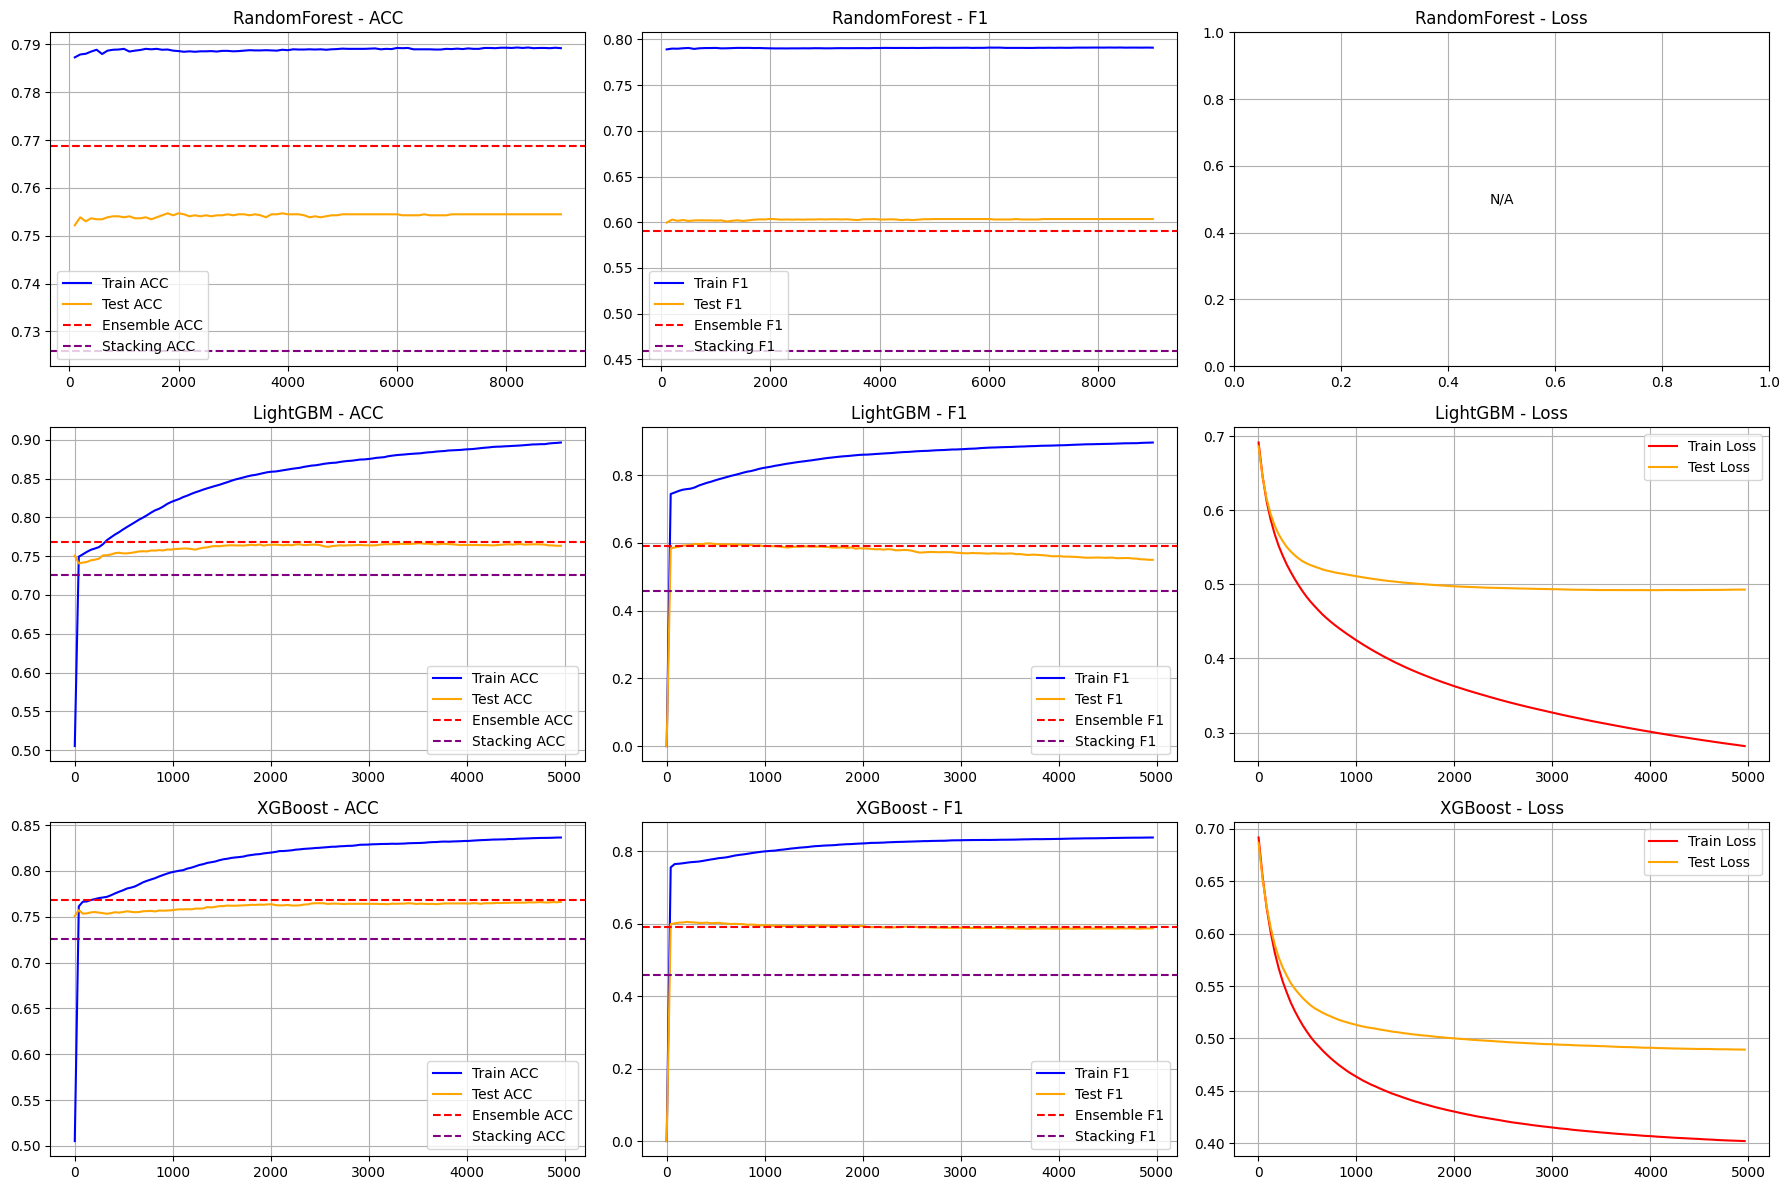


📊 Ranking by F1:
          Model  Accuracy        F1
0  RandomForest  0.754489  0.603506
1      Ensemble  0.768685  0.590842
2       XGBoost  0.765553  0.586676
3      LightGBM  0.763674  0.550437
4      Stacking  0.725887  0.459003


In [ ]:
# RF / LightGBM / XGBoost + Ensemble (soft voting) & Stacking (meta LGBM)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# -------------------------------
# 1) 準備 X_train_df / X_test_df （確保 feature names 被保留）
#    如果你原本就有 x_train, x_test 為 DataFrame，會直接使用它們；如果只有 numpy arrays，會嘗試用原本的欄位名，否則自動產生 generic names
# -------------------------------
def ensure_dataframe(X_array_or_df, reference_df=None, name="X"):
    # return DataFrame version and columns
    if isinstance(X_array_or_df, pd.DataFrame):
        return X_array_or_df.copy()
    try:
        # if it's numpy array, try to get column names from reference_df if provided
        arr = np.asarray(X_array_or_df)
        if reference_df is not None and isinstance(reference_df, pd.DataFrame):
            cols = list(reference_df.columns)
        else:
            cols = [f"f{i}" for i in range(arr.shape[1])]
        return pd.DataFrame(arr, columns=cols)
    except Exception:
        raise ValueError(f"Cannot convert {name} to DataFrame")

# Try to locate training variables in current namespace
# (the user said they have x_train, x_test, x_train_array, x_test_array)
globals_vars = globals()

# Prefer x_train (DataFrame) if exists, else x_train_array
if 'x_train' in globals_vars and isinstance(globals_vars['x_train'], pd.DataFrame):
    X_train_df = globals_vars['x_train'].copy()
    X_test_df  = globals_vars['x_test'].copy()
else:
    # fallback to arrays; try to use x_train_array and original column names if available
    X_train_arr = globals_vars.get('x_train_array', globals_vars.get('x_train', None))
    X_test_arr  = globals_vars.get('x_test_array', globals_vars.get('x_test', None))
    # try to find a reference df for columns
    ref_df = globals_vars.get('x_train', None)
    X_train_df = ensure_dataframe(X_train_arr, reference_df=ref_df, name='x_train')
    X_test_df  = ensure_dataframe(X_test_arr, reference_df=ref_df, name='x_test')

# Targets
if 'y_train' in globals_vars and 'y_test' in globals_vars:
    y_train = globals_vars['y_train']
    y_test  = globals_vars['y_test']
else:
    # try numpy arrays
    y_train = globals_vars.get('y_train_array', globals_vars.get('y_train', None))
    y_test  = globals_vars.get('y_test_array', globals_vars.get('y_test', None))

# ensure shapes
X_train_df = pd.DataFrame(X_train_df)
X_test_df  = pd.DataFrame(X_test_df)
y_train = np.asarray(y_train)
y_test  = np.asarray(y_test)

# Fix feature names for LightGBM compatibility (remove [, ], < characters)
def clean_feature_names(df):
    """Clean feature names to be compatible with LightGBM"""
    new_columns = []
    for col in df.columns:
        # Replace problematic characters
        new_col = str(col).replace('[', '').replace(']', '').replace('<', 'less_than_')
        new_columns.append(new_col)
    df.columns = new_columns
    return df

X_train_df = clean_feature_names(X_train_df)
X_test_df = clean_feature_names(X_test_df)

print("Data shapes:", X_train_df.shape, X_test_df.shape, y_train.shape, y_test.shape)

# -------------------------------
# 2) 建模參數
# -------------------------------
rf_params = dict(
    n_estimators=9000,
    warm_start=True,
    max_depth=266,
    min_samples_split=48,
    min_samples_leaf=24,
    max_features="sqrt",
    bootstrap=False,
    random_state=66,
    n_jobs=-1
)
lgb_params = dict(
    n_estimators=5000,
    learning_rate=0.005,
    max_depth=40,
    num_leaves=222,
    subsample=0.55,
    colsample_bytree=0.93,
    min_child_samples=144,
    reg_alpha=3.07,
    reg_lambda=1.79e-07,
    random_state=66,
    n_jobs=-1
)
xgb_params = dict(
    n_estimators=5000,
    learning_rate=0.005,
    max_depth=43,
    subsample=0.62,
    colsample_bytree=0.63,
    gamma=4.27,
    reg_alpha=4.78,
    reg_lambda=5.82,
    eval_metric="logloss",
    random_state=66,
    n_jobs=-1,
    use_label_encoder=False
)

# instantiate models
rf_model = RandomForestClassifier(**rf_params)
lgb_model = LGBMClassifier(**lgb_params)
xgb_model = XGBClassifier(**xgb_params)

# -------------------------------
# 3) 訓練：RF (每 500 棵樹取樣 30 個點)，LGBM/XGB(記錄 evals_result 並每 step 評估 ACC/F1)
# -------------------------------
history = {}
final_metrics = {}

# ----- RandomForest: 每 100 棵一點 (90 points) -----
print("訓練模型: RandomForest")
n_points_rf = 90
max_trees = rf_params['n_estimators']
step_rf = max(1, max_trees // n_points_rf)
n_trees_list = list(range(step_rf, max_trees+1, step_rf))[:n_points_rf]  # 確保 90 個點
acc_train_rf, acc_test_rf, f1_train_rf, f1_test_rf = [], [], [], []

for n in n_trees_list:
    rf_model.set_params(n_estimators=n)
    rf_model.fit(X_train_df, y_train)
    # train / test predictions
    y_tr = rf_model.predict(X_train_df)
    y_te = rf_model.predict(X_test_df)
    acc_train_rf.append(accuracy_score(y_train, y_tr))
    acc_test_rf.append(accuracy_score(y_test, y_te))
    f1_train_rf.append(f1_score(y_train, y_tr))
    f1_test_rf.append(f1_score(y_test, y_te))

history['RandomForest'] = {
    "iters": n_trees_list,
    "acc_train": acc_train_rf, "acc_test": acc_test_rf,
    "f1_train": f1_train_rf, "f1_test": f1_test_rf,
    "loss_train": None, "loss_test": None
}
final_metrics['RandomForest'] = {"acc": acc_test_rf[-1], "f1": f1_test_rf[-1]}

# ----- LightGBM: 訓練並取得 evals_result，為避免太慢只採樣 n_points 個點 -----
print("訓練模型: LightGBM")
# fit with eval_set to record training & validation loss
lgb_model.fit(
    X_train_df, y_train,
    eval_set=[(X_train_df, y_train), (X_test_df, y_test)],
    eval_metric="binary_logloss",
    callbacks=[lgb.log_evaluation(0)]  # no printing but keep evals_result_
)
evals_lgb = lgb_model.evals_result_
loss_train_full = evals_lgb['training']['binary_logloss']
loss_test_full  = evals_lgb['valid_1']['binary_logloss']

n_points = 120  # number of points to sample for plotting (調整以免太慢)
step = max(1, len(loss_train_full) // n_points)
iters_lgb = list(range(1, len(loss_train_full)+1, step))
acc_train_lgb, acc_test_lgb, f1_train_lgb, f1_test_lgb = [], [], [], []
for it in iters_lgb:
    # LightGBM scikit wrapper supports predict_proba with num_iteration
    prob_tr = lgb_model.predict_proba(X_train_df, num_iteration=it)[:,1]
    prob_te = lgb_model.predict_proba(X_test_df, num_iteration=it)[:,1]
    pred_tr = (prob_tr > 0.5).astype(int)
    pred_te = (prob_te > 0.5).astype(int)
    acc_train_lgb.append(accuracy_score(y_train, pred_tr))
    acc_test_lgb.append(accuracy_score(y_test, pred_te))
    f1_train_lgb.append(f1_score(y_train, pred_tr))
    f1_test_lgb.append(f1_score(y_test, pred_te))

history['LightGBM'] = {
    "iters": iters_lgb,
    "acc_train": acc_train_lgb, "acc_test": acc_test_lgb,
    "f1_train": f1_train_lgb, "f1_test": f1_test_lgb,
    "loss_train": [loss_train_full[i-1] for i in iters_lgb],
    "loss_test": [loss_test_full[i-1] for i in iters_lgb]
}
final_metrics['LightGBM'] = {"acc": accuracy_score(y_test, (lgb_model.predict_proba(X_test_df)[:,1]>0.5).astype(int)),
                            "f1": f1_score(y_test, (lgb_model.predict_proba(X_test_df)[:,1]>0.5).astype(int))}

# ----- XGBoost: fit and record evals_result; sample points -----
print("訓練模型: XGBoost")
xgb_model.fit(
    X_train_df, y_train,
    eval_set=[(X_train_df, y_train), (X_test_df, y_test)],
    verbose=False
)
evals_xgb = xgb_model.evals_result()
loss_train_full_x = evals_xgb['validation_0']['logloss']
loss_test_full_x  = evals_xgb['validation_1']['logloss']

step_x = max(1, len(loss_train_full_x)//n_points)
iters_xgb = list(range(1, len(loss_train_full_x)+1, step_x))
acc_train_xgb, acc_test_xgb, f1_train_xgb, f1_test_xgb = [], [], [], []
for it in iters_xgb:
    try:
        prob_tr = xgb_model.predict_proba(X_train_df, iteration_range=(0, it))[:,1]
        prob_te = xgb_model.predict_proba(X_test_df, iteration_range=(0, it))[:,1]
    except TypeError:
        # older xgboost versions may not support iteration_range in sklearn wrapper
        # fallback: use raw booster
        from xgboost import DMatrix
        dtr = DMatrix(X_train_df, label=y_train)
        dte = DMatrix(X_test_df, label=y_test)
        prob_tr = xgb_model.get_booster().predict(dtr, ntree_limit=it)
        prob_te = xgb_model.get_booster().predict(dte, ntree_limit=it)
    pred_tr = (prob_tr > 0.5).astype(int)
    pred_te = (prob_te > 0.5).astype(int)
    acc_train_xgb.append(accuracy_score(y_train, pred_tr))
    acc_test_xgb.append(accuracy_score(y_test, pred_te))
    f1_train_xgb.append(f1_score(y_train, pred_tr))
    f1_test_xgb.append(f1_score(y_test, pred_te))

history['XGBoost'] = {
    "iters": iters_xgb,
    "acc_train": acc_train_xgb, "acc_test": acc_test_xgb,
    "f1_train": f1_train_xgb, "f1_test": f1_test_xgb,
    "loss_train": [loss_train_full_x[i-1] for i in iters_xgb],
    "loss_test":  [loss_test_full_x[i-1] for i in iters_xgb]
}
final_metrics['XGBoost'] = {"acc": accuracy_score(y_test, (xgb_model.predict_proba(X_test_df)[:,1]>0.5).astype(int)),
                            "f1": f1_score(y_test, (xgb_model.predict_proba(X_test_df)[:,1]>0.5).astype(int))}

# -------------------------------
# 4) 手動 Ensemble (soft voting by probability) 與 Stacking (meta-learner)
#    Use the trained models above, combine predict_proba on X_test/X_train
# -------------------------------
print("計算 Ensemble / Stacking")

# base model probabilities on train and test
prob_train_stack = np.vstack([
    rf_model.predict_proba(X_train_df)[:,1],
    lgb_model.predict_proba(X_train_df)[:,1],
    xgb_model.predict_proba(X_train_df)[:,1]
]).T
prob_test_stack = np.vstack([
    rf_model.predict_proba(X_test_df)[:,1],
    lgb_model.predict_proba(X_test_df)[:,1],
    xgb_model.predict_proba(X_test_df)[:,1]
]).T

# weights from base final f1 (to favor better models)
w_rf = final_metrics['RandomForest']['f1']
w_lgb = final_metrics['LightGBM']['f1']
w_xgb = final_metrics['XGBoost']['f1']
weights = np.array([w_rf, w_lgb, w_xgb])
# avoid zero
weights = np.where(weights <= 0, 1.0, weights)

# soft voting
prob_test_ens = (prob_test_stack * weights.reshape(1,-1)).sum(axis=1) / weights.sum()
pred_test_ens = (prob_test_ens > 0.5).astype(int)
ens_acc = accuracy_score(y_test, pred_test_ens)
ens_f1  = f1_score(y_test, pred_test_ens)

# stacking: train meta-learner on train-level probs
meta = LGBMClassifier(n_estimators=3000, learning_rate=0.008, num_leaves=256, random_state=66)
meta.fit(prob_train_stack, y_train)
prob_test_meta = meta.predict_proba(prob_test_stack)[:,1]
pred_test_meta = (prob_test_meta > 0.5).astype(int)
stack_acc = accuracy_score(y_test, pred_test_meta)
stack_f1  = f1_score(y_test, pred_test_meta)

print(f"Ensemble (soft weighted) ACC={ens_acc:.4f}, F1={ens_f1:.4f}")
print(f"Stacking (meta LGBM) ACC={stack_acc:.4f}, F1={stack_f1:.4f}")

# -------------------------------
# 5) Plot: 3 rows x 3 cols (RF / LGBM / XGB) each: ACC / F1 / Loss (train vs test)
# -------------------------------
fig, axes = plt.subplots(3, 3, figsize=(18, 12))

model_names = ['RandomForest', 'LightGBM', 'XGBoost']
for i, name in enumerate(model_names):
    hist = history[name]
    iters = hist['iters']

    # ACC
    axes[i,0].plot(iters, hist['acc_train'], label='Train ACC', color='blue')
    axes[i,0].plot(iters, hist['acc_test'], label='Test ACC', color='orange')
    axes[i,0].axhline(y=ens_acc, color='red', linestyle='--', label='Ensemble ACC')
    axes[i,0].axhline(y=stack_acc, color='purple', linestyle='--', label='Stacking ACC')
    axes[i,0].set_title(f"{name} - ACC")
    axes[i,0].legend(); axes[i,0].grid(True)

    # F1
    axes[i,1].plot(iters, hist['f1_train'], label='Train F1', color='blue')
    axes[i,1].plot(iters, hist['f1_test'], label='Test F1', color='orange')
    axes[i,1].axhline(y=ens_f1, color='red', linestyle='--', label='Ensemble F1')
    axes[i,1].axhline(y=stack_f1, color='purple', linestyle='--', label='Stacking F1')
    axes[i,1].set_title(f"{name} - F1")
    axes[i,1].legend(); axes[i,1].grid(True)

    # Loss
    if hist['loss_train'] and len(hist['loss_train'])>0:
        axes[i,2].plot(hist['iters'], hist['loss_train'], label='Train Loss', color='red')
        axes[i,2].plot(hist['iters'], hist['loss_test'], label='Test Loss', color='orange')
        axes[i,2].legend()
    else:
        axes[i,2].text(0.5,0.5,"N/A", ha='center', va='center')
    axes[i,2].set_title(f"{name} - Loss")
    axes[i,2].grid(True)

plt.tight_layout()
plt.show()

# -------------------------------
# 6) 最終排名表 (by F1)
# -------------------------------
df_results = pd.DataFrame([
    ['RandomForest', final_metrics['RandomForest']['acc'], final_metrics['RandomForest']['f1']],
    ['LightGBM', final_metrics['LightGBM']['acc'], final_metrics['LightGBM']['f1']],
    ['XGBoost', final_metrics['XGBoost']['acc'], final_metrics['XGBoost']['f1']],
    ['Ensemble', ens_acc, ens_f1],
    ['Stacking', stack_acc, stack_f1]
], columns=['Model','Accuracy','F1']).sort_values('F1', ascending=False).reset_index(drop=True)

print("\n📊 Ranking by F1:")
print(df_results)

#### 表現依舊不好，試試特徵選擇....使用 lgbm.feature_importances。變更差了@@

                   Feature  Importance
0   city_development_index         306
2                city_freq         248
1           training_hours         201
43          experience_>20         127
58          last_new_job_1          76
62         last_new_job_>4          68
48      company_size_50-99          65
35            experience_3          64
37            experience_5          60
23           experience_10          57
36            experience_4          55
41            experience_9          55
44      company_size_10/49          55
33            experience_2          53
42           experience_<1          52
47     company_size_10000+          52
45    company_size_100-500          52
60          last_new_job_3          52
59          last_new_job_2          49
61          last_new_job_4          49


<Figure size 1000x600 with 0 Axes>

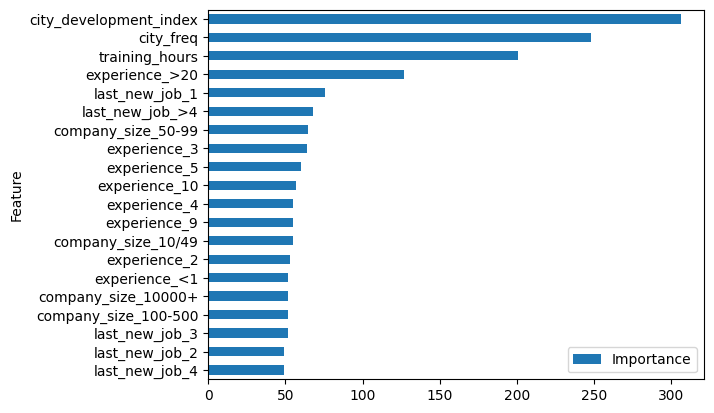

In [18]:
import lightgbm as lgb
import pandas as pd
import matplotlib.pyplot as plt

# 建立 LGBM 模型
lgb_model = lgb.LGBMClassifier(random_state=666)
lgb_model.fit(x_train, y_train)

# 取得特徵重要性
importances = lgb_model.feature_importances_
feature_names = x_train.columns

# 建立 dataframe
feat_importances = pd.DataFrame({
    "Feature": feature_names,
    "Importance": importances
}).sort_values(by="Importance", ascending=False)

print(feat_importances.head(20))  # 查看前20重要特徵

# 畫圖
plt.figure(figsize=(10,6))
feat_importances.head(20).plot(kind="barh", x="Feature", y="Importance")
plt.gca().invert_yaxis()
plt.show()


訓練模型: RandomForest
訓練模型: LightGBM
訓練模型: XGBoost
訓練模型: CatBoost


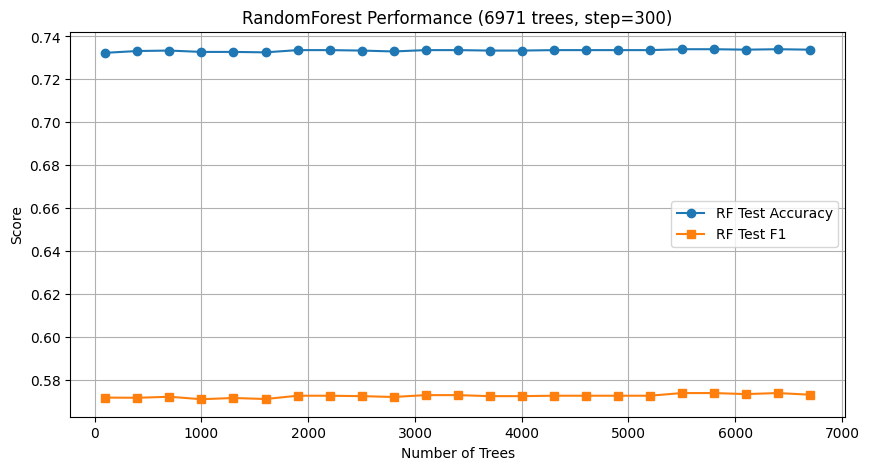

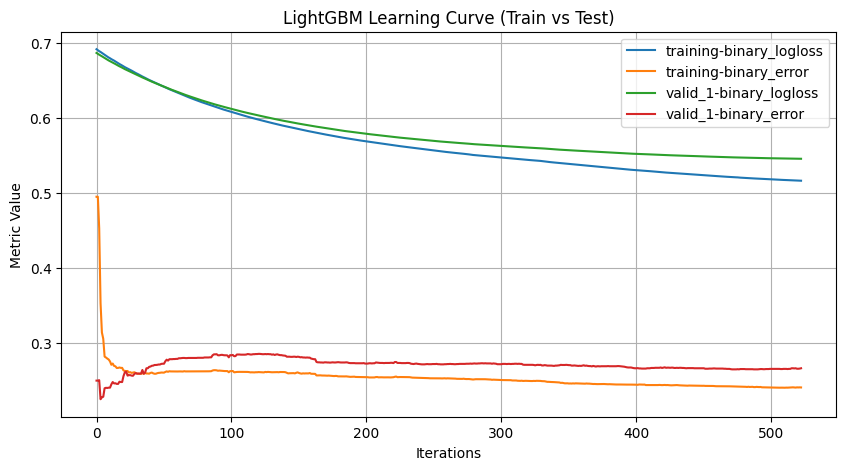

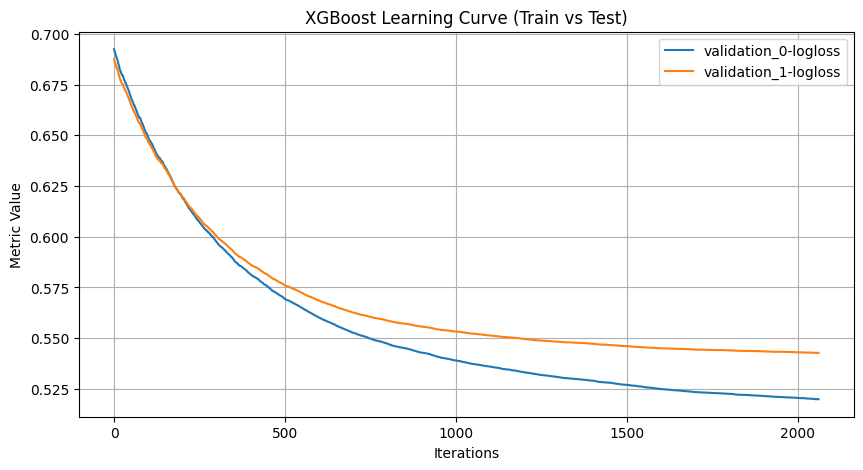

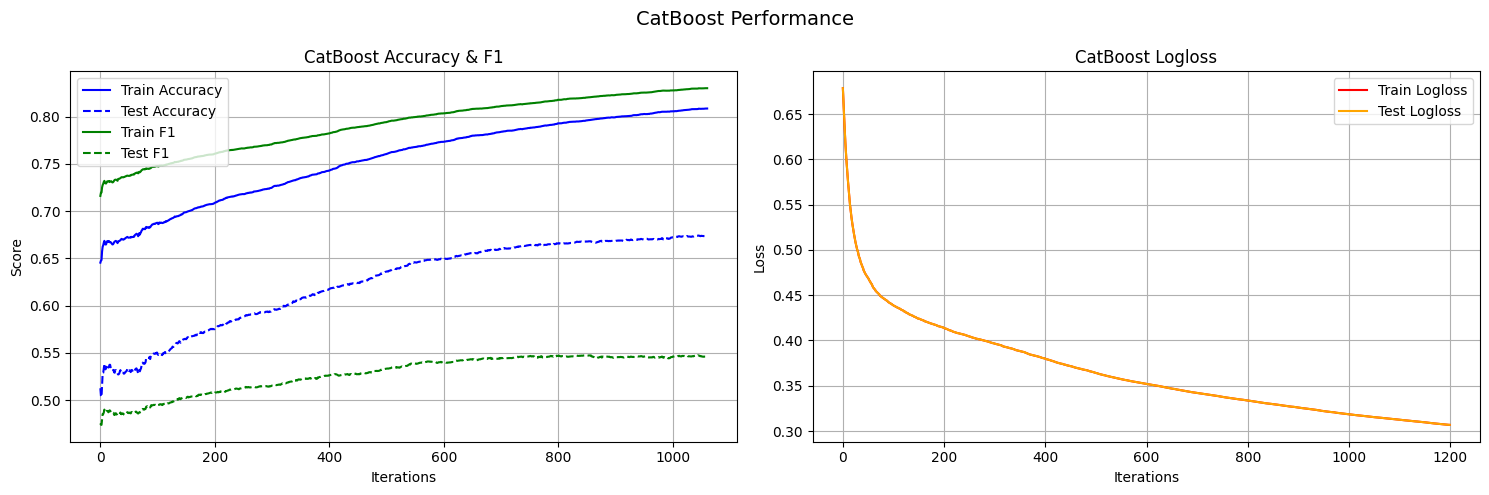


📊 模型表現排名 (依 F1 Score 排序)：
              Accuracy        F1
XGBoost       0.733820  0.575142
RandomForest  0.733820  0.573150
LightGBM      0.734238  0.569205
CatBoost      0.674322  0.546512


In [28]:
import pandas as pd
import numpy as np
import lightgbm as lgb
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier, Pool

# ==== Step 1. 篩選特徵 ====
selected_features = feat_importances[feat_importances["Importance"] >= 55]["Feature"].tolist()
X_train_sel = x_train[selected_features]
X_test_sel = x_test[selected_features]

# ==== Step 2. 建立模型清單 ====
models = {
    "RandomForest": RandomForestClassifier(
        n_estimators=6971,
        warm_start=True,
        max_depth=126,
        min_samples_split=38,
        min_samples_leaf=24,
        max_features="sqrt",
        bootstrap=False,
        random_state=666,
        n_jobs=-1
    ),
    "LightGBM": LGBMClassifier(
        n_estimators=523,
        learning_rate=0.005008924392163075,
        max_depth=9,
        num_leaves=192,
        subsample=0.5535119237971283,
        colsample_bytree=0.9297911008830493,
        min_child_samples=144,
        reg_alpha=3.070888449354123,
        reg_lambda=1.7932775669692494e-07,
        random_state=666,
        n_jobs=-1
    ),
    "XGBoost": XGBClassifier(
        n_estimators=2062,
        learning_rate=0.0032948503804379617,
        max_depth=43,
        subsample=0.5257325090502304,
        colsample_bytree=0.5339291410689933,
        gamma=4.276651252581944,
        reg_alpha=4.782618468758816,
        reg_lambda=5.824372818389731,
        eval_metric="logloss",
        random_state=666,
        n_jobs=-1
    ),
    "CatBoost": CatBoostClassifier(
        iterations=1200,
        depth=8,
        learning_rate=0.03,
        l2_leaf_reg=5,
        random_state=666,
        class_weights=[1, 3],
        verbose=0
    )
}

# ==== Step 3. 訓練與記錄 ====
history = {}
final_scores = {}

for name, model in models.items():
    print(f"訓練模型: {name}")

    if name == "RandomForest":
        rf_acc, rf_f1 = [], []
        n_trees_range = range(100, 6972, 300)
        for n in n_trees_range:
            rf = RandomForestClassifier(
                n_estimators=n,
                warm_start=True,
                max_depth=126,
                min_samples_split=38,
                min_samples_leaf=24,
                max_features="sqrt",
                bootstrap=False,
                random_state=6971,
                n_jobs=-1
            )
            rf.fit(X_train_sel, y_train)
            y_pred = rf.predict(X_test_sel)
            rf_acc.append(accuracy_score(y_test, y_pred))
            rf_f1.append(f1_score(y_test, y_pred))
        history[name] = {"trees": list(n_trees_range), "acc": rf_acc, "f1": rf_f1}
        final_scores[name] = {"Accuracy": rf_acc[-1], "F1": rf_f1[-1]}

    elif name == "LightGBM":
        model.fit(
            X_train_sel, y_train,
            eval_set=[(X_train_sel, y_train), (X_test_sel, y_test)],
            eval_metric=["logloss", "error"],
            callbacks=[lgb.log_evaluation(period=0)]
        )
        evals_result = model.evals_result_
        history[name] = {"evals": evals_result}
        y_pred = model.predict(X_test_sel)
        final_scores[name] = {"Accuracy": accuracy_score(y_test, y_pred),
                              "F1": f1_score(y_test, y_pred)}

    elif name == "XGBoost":
        model.fit(
            X_train_sel, y_train,
            eval_set=[(X_train_sel, y_train), (X_test_sel, y_test)],
            verbose=False
        )
        evals_result = model.evals_result()
        history[name] = {"evals": evals_result}
        y_pred = model.predict(X_test_sel)
        final_scores[name] = {"Accuracy": accuracy_score(y_test, y_pred),
                              "F1": f1_score(y_test, y_pred)}

    elif name == "CatBoost":
        model.fit(
            X_train_sel, y_train,
            eval_set=[(X_train_sel, y_train), (X_test_sel, y_test)],
            verbose=False
        )
        evals_result = model.get_evals_result()
        acc_train, f1_train, acc_test, f1_test = [], [], [], []
        for i in range(1, model.tree_count_ + 1):
            preds_train = model.predict(X_train_sel, ntree_end=i)
            acc_train.append(accuracy_score(y_train, preds_train))
            f1_train.append(f1_score(y_train, preds_train))
            preds_test = model.predict(X_test_sel, ntree_end=i)
            acc_test.append(accuracy_score(y_test, preds_test))
            f1_test.append(f1_score(y_test, preds_test))
        history[name] = {"evals": evals_result,
                         "acc_train": acc_train, "f1_train": f1_train,
                         "acc_test": acc_test, "f1_test": f1_test}
        final_scores[name] = {"Accuracy": acc_test[-1], "F1": f1_test[-1]}

# ==== Step 4. 視覺化 ====

# RandomForest
rf_hist = history["RandomForest"]
plt.figure(figsize=(10,5))
plt.plot(rf_hist["trees"], rf_hist["acc"], marker="o", label="RF Test Accuracy")
plt.plot(rf_hist["trees"], rf_hist["f1"], marker="s", label="RF Test F1")
plt.title("RandomForest Performance (6971 trees, step=300)")
plt.xlabel("Number of Trees"); plt.ylabel("Score"); plt.legend(); plt.grid(True)
plt.show()

# LightGBM / XGBoost
for name in ["LightGBM", "XGBoost"]:
    evals = history[name]["evals"]
    plt.figure(figsize=(10,5))
    for dataset, metrics in evals.items():
        for metric, values in metrics.items():
            plt.plot(values, label=f"{dataset}-{metric}")
    plt.title(f"{name} Learning Curve (Train vs Test)")
    plt.xlabel("Iterations"); plt.ylabel("Metric Value"); plt.legend(); plt.grid(True)
    plt.show()

# CatBoost
cb_hist = history["CatBoost"]
evals = cb_hist["evals"]
plt.figure(figsize=(15,5))

# 左邊：ACC/F1
plt.subplot(1,2,1)
plt.plot(cb_hist["acc_train"], label="Train Accuracy", color="blue")
plt.plot(cb_hist["acc_test"], label="Test Accuracy", color="blue", linestyle="--")
plt.plot(cb_hist["f1_train"], label="Train F1", color="green")
plt.plot(cb_hist["f1_test"], label="Test F1", color="green", linestyle="--")
plt.title("CatBoost Accuracy & F1")
plt.xlabel("Iterations"); plt.ylabel("Score"); plt.legend(); plt.grid(True)

# 右邊：LOSS（修正 validation_0）
plt.subplot(1,2,2)
plt.plot(evals["learn"]["Logloss"], label="Train Logloss", color="red")
plt.plot(evals["validation_0"]["Logloss"], label="Test Logloss", color="orange")
plt.title("CatBoost Logloss")
plt.xlabel("Iterations"); plt.ylabel("Loss"); plt.legend(); plt.grid(True)

plt.suptitle("CatBoost Performance", fontsize=14)
plt.tight_layout()
plt.show()

# ==== Step 5. 排名表 ====
ranking_df = pd.DataFrame(final_scores).T.sort_values(by="F1", ascending=False)
print("\n📊 模型表現排名 (依 F1 Score 排序)：")
print(ranking_df)


### 有點過擬合...試試剪枝?
f1-score有變好一點點...
(做作業時你可以刪掉此block)


In [ ]:
"""
model = RandomForestClassifier(max_depth=10)
model.fit(x_train_array, y_train_array)

y_pred=model.predict(x_test_array)

accuracy = accuracy_score(y_test_array, y_pred)
print(f"Accuracy: {accuracy}")
f_1_score = f1_score(y_test_array, y_pred)
print(f"F1 Score: {f_1_score}")
"""

Accuracy: 0.7582463465553236
F1 Score: 0.5881934566145092


### 其他你可以嘗試提高性能的方法:(不強制)
1. 更合理的前處理(ex. experience欄位轉成數值型變數)
2. 選擇一般情況表現較佳的模型(ex. xgboost, catboost)
3. 用其他方法可考慮Regularization